#### 👕 클로젯셰어 과제 가이드라인 

**1. Data**

    1) 과제 data ( 최근 3개월간 신규 구매 데이터 일부 )
        - brandnm : 아이템 브랜드명
        - goodsnm : 아이템 명
        - USER : 개별 유저 식별 값
        - reg_date : 개별 유저 가입일
        - order_date : 아이템 주문일
        - p_type : 주문 상품 종류 [7days (7일권) / 4days (4일권)]
        - sub_type : 주문 상품 카테고리 [BA – 가방 / O – 아우터 / D – 드레스 / T – 상의 / B – 하의 / TB – 투피스]
        - app_yn : 어플리케이션 사용 여부 [Y – 어플리케이션 사용 / (공백) – 어플리케이션 미사용]
    
    2) 외부 data
        - 대여 가격 (클로젯셰어 크롤링)
        - 클로젯셰어 검색지수 (네이버 트렌드)
        - 럭셔리 브랜드 리스트 (2021기준 데이터 다운로드)


**2. 전처리**

    - 결측치
    - 파생변수 및 추가 테이블 생성



**3. EDA 및 분석결과 기반 제안사항**

> **1) 유저 그룹핑 기반 분석**
        - seg_lag (주문시점-가입시점) : 가입일reg_date 구매일자 order_date간 차이
        - seg_new (가입시점 2021) : 신규유저(1) vs 기존유저(0)
        - seg_heavy (주문건수 4건 이상) : 헤비유저(1) vs 라이트유저(0)
        - seg_luxury (전체 구매 품목 수 중 럭셔리제품 비율)
        
> **2) 월별 트렌드 기반 분석**
        - 월별 선호 브랜드
        - 월별 선호 제품
        - 유저별 대여제품 건수
        - 월별 선호 이용권



#### 모듈 import

In [1]:
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style(style="white")
plt.rc('font', family='Malgun Gothic') 
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['axes.unicode_minus'] = False    # minus

from matplotlib_venn import venn3, venn3_circles
from matplotlib_venn import venn2, venn2_circles

# interactive
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
from plotly.offline import iplot
cf.go_offline()

# 노트북 세팅
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')

# 연관분석
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [2]:
pd.options.display.float_format = '{:.2f}'.format


## Data import

### 과제 data

In [3]:
# 과제 data
closet = pd.read_excel('../week3/클로젯셰어_과제DB 대체 자료.xlsx',)
df = closet.copy()
# col > lower
df.columns=list(map(lambda x: x.lower(),df.columns))

In [4]:
df.head(2)

,brandnm,goodsnm,user,reg_date,order_date,p_type,sub_type,app_yn
0,Gucci,flower dionysus shoulder bag beige,a161237,2019-12-06,2021-01-15,7days,BA,Y
1,El estilo de Claire,beads cropped jacket black,a1140859,2021-01-02,2021-01-15,4days,O,NaN


### 외부 data

In [5]:
# 크롤링 data 가격정보
price = pd.read_excel('../week3/tag_price_df.xlsx')
# remove space
price.columns=list(map(lambda x: x.replace(' ',''),price.columns))
price=price.iloc[:,1:]
price.head(2)

,brandnm,goodsnm,tag,4d_price,7d_price
0,Gucci,flower dionysus shoulder bag beige,#위켄드,49000.00,59000.00
1,Gucci,dionysus cross bag,#위켄드,49000.00,59000.00


In [6]:
# 클로젯셰어 네이버 트렌드 정보
navertrend = pd.read_excel('../week3/navertrend.xlsx')
navertrend.head()

,date,index
0,2021-01-01,33.18
1,2021-01-02,38.07
2,2021-01-03,46.10
3,2021-01-04,52.04
4,2021-01-05,59.14


### 데이터 개요

#### 과제 data

In [7]:
df.head(33)

,brandnm,goodsnm,user,reg_date,order_date,p_type,sub_type,app_yn
0,Gucci,flower dionysus shoulder bag beige,a161237,2019-12-06,2021-01-15,7days,BA,Y
1,El estilo de Claire,beads cropped jacket black,a1140859,2021-01-02,2021-01-15,4days,O,NaN
2,Danha,embroidery point oriental mini skirt blue,a1140859,2021-01-02,2021-01-15,4days,B,NaN
3,Danha,graphics pattern top pink,a1140859,2021-01-02,2021-01-15,4days,T,NaN
4,Burberry London,buckle basic pattern zipup-jumper navy,a1140740,2021-01-01,2021-01-15,7days,O,Y
5,Prada,ruffle detail long coat,a110231,2018-10-18,2021-01-15,7days,O,Y
6,Max Mara,strap basic pattern wrap-coat black,a1139960,2020-12-26,2021-01-15,7days,O,Y
7,Molliolli,pocket basic pattern fur-outer ivory,a115159,2019-01-29,2021-01-15,4days,O,Y
8,Gucci,dionysus cross bag,a1143028,2021-01-14,2021-01-15,4days,BA,Y
9,Sandro,pattern pointed cardigan black,a117306,2019-03-02,2021-01-15,7days,O,Y


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1471 entries, 0 to 1470
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   brandnm     1442 non-null   object        
 1   goodsnm     1471 non-null   object        
 2   user        1471 non-null   object        
 3   reg_date    1466 non-null   datetime64[ns]
 4   order_date  1471 non-null   datetime64[ns]
 5   p_type      1471 non-null   object        
 6   sub_type    1471 non-null   object        
 7   app_yn      1295 non-null   object        
dtypes: datetime64[ns](2), object(6)
memory usage: 92.1+ KB


In [9]:
df.describe().T

,count,unique,top,freq,first,last
brandnm,1442,245,Gucci,232,NaT,NaT
goodsnm,1471,979,chevron quilted cross bag black,23,NaT,NaT
user,1471,1234,a1149461,11,NaT,NaT
reg_date,1466,368,2021-03-16 00:00:00,44,2017-06-24,2021-03-31
order_date,1471,90,2021-03-24 00:00:00,47,2021-01-01,2021-03-31
p_type,1471,2,4days,894,NaT,NaT
sub_type,1471,6,BA,692,NaT,NaT
app_yn,1295,1,Y,1295,NaT,NaT


#### 외부 data
1. `price` 상품별 가격 정보 - 크롤링
2. `navertrend` 클로젯셰어 검색 트렌드 정보 - https://datalab.naver.com/keyword/trendResult.naver?hashKey=N_d01ade15c99d850887f521c7b4b3da99

##### price

In [10]:
price.head() 

,brandnm,goodsnm,tag,4d_price,7d_price
0,Gucci,flower dionysus shoulder bag beige,#위켄드,49000.00,59000.00
1,Gucci,dionysus cross bag,#위켄드,49000.00,59000.00
2,Tory Burch,flower ethnic pattern cross bag white,#위켄드,34000.00,44000.00
3,Chloe,faye small bag black,#오피스 #위켄드,34000.00,44000.00
4,Prada,logo hobo bag black,#일상,39000.00,49000.00


In [11]:
print(price['4d_price'].unique())
print(price['7d_price'].unique())

[49000. 34000. 39000. 59000.    nan 29000. 15000. 24000. 38000. 19000.
 12000.]
[59000. 44000. 49000. 69000.    nan 39000. 25000. 34000. 58000. 29000.
 22000.]


In [12]:
price.describe().T

,count,mean,std,min,25%,50%,75%,max
4d_price,540.00,39983.33,10221.74,12000.00,34000.00,39000.00,49000.00,59000.00
7d_price,540.00,50001.85,10227.20,22000.00,44000.00,49000.00,59000.00,69000.00


##### navertrend

In [13]:
navertrend.describe().T

,count,mean,std,min,25%,50%,75%,max
index,90.00,44.27,12.70,22.82,35.51,41.56,51.28,100.00


In [14]:
navertrend['date']=pd.to_datetime(navertrend['date'])
navertrend['month']=navertrend['date'].dt.strftime('%m')
navertrend['dayofweek']=navertrend['date'].dt.dayofweek
navertrend['week']=navertrend['date'].dt.week

In [15]:
navertrend.head(3)

,date,index,month,dayofweek,week
0,2021-01-01,33.18,01,4,53
1,2021-01-02,38.07,01,5,53
2,2021-01-03,46.10,01,6,53


### 데이터 개요 정리

In [16]:
# 상품 카테고리 한글로
def rename_cate(row):
    if pd.isnull(row):
        return np.nan
    else:
        return row.replace('BA', '가방').replace('O', '아우터').replace('D', '드레스').replace('TP','투피스').replace('T', '상의').\
    replace('B', '하의')    
    
df['sub_type'] = df['sub_type'].apply(rename_cate)

In [17]:
print('브랜드 수:', df.brandnm.nunique(),'\n')
print('상품 수:', df.goodsnm.nunique(),'\n')
print('유저 수:', df.user.nunique(),'\n')
print('구매 타입 수:', df.p_type.nunique())
print('구매 타입 수:', df.p_type.unique(),'\n')
print('서브 타입 수:', df.sub_type.nunique())
print('서브 타입 수:', df.sub_type.unique(),'\n')
print('가입 정보 기간:', pd.to_datetime(df['reg_date']).min() ,"~", pd.to_datetime(df['reg_date']).max())
print('구매 정보 기간:', df.order_date.min() ,"~", df.order_date.max())

브랜드 수: 245 

상품 수: 979 

유저 수: 1234 

구매 타입 수: 2
구매 타입 수: ['7days' '4days'] 

서브 타입 수: 6
서브 타입 수: ['가방' '아우터' '하의' '상의' '드레스' '투피스'] 

가입 정보 기간: 2017-06-24 00:00:00 ~ 2021-03-31 00:00:00
구매 정보 기간: 2021-01-01 00:00:00 ~ 2021-03-31 00:00:00


In [18]:
df.groupby('user')['order_date'].count().sort_values().to_frame().reset_index().value_counts('order_date').to_frame().reset_index().rename(columns={0:'유저 수',                                                                                                                              'order_date':'주문 건 수'})

,주문 건 수,유저 수
0,1,1095
1,2,89
2,3,33
3,4,8
4,6,3
5,7,2
6,11,1
7,10,1
8,9,1
9,5,1


In [19]:
df.brandnm.value_counts().head(10).to_frame()

,brandnm
Gucci,232
Chanel,90
Saint Laurent,86
Louis Vuitton,79
Prada,58
Burberry,53
Yves Saint Laurent,38
Thom Browne,33
Fendi,29
Celine,28


## 전처리
1. 결측치 확인/처리 (brandnm, reg_date, app_yn)
2. 파생변수 추가 (날짜, 럭셔리 브랜드, 유저그룹핑 변수)
3. 테이블 추가 (df_user : 유저별 정보 테이블)

### 전처리 1 : 결측치 확인/처리
- brandnm : 검색, fillna('N/A')
- reg_date : fillna(method='pad')
- app_yn : fillna(0)

In [20]:
df.isnull().sum()

brandnm        29
goodsnm         0
user            0
reg_date        5
order_date      0
p_type          0
sub_type        0
app_yn        176
dtype: int64

#### brandnm  : 검색, fillna('NA')

##### 검색

In [21]:
df.loc[146, 'brandnm'] = 'Fendi' # 상의는 YCH ?
df.loc[147, 'brandnm'] = 'Mojosphine'
df.loc[160, 'brandnm'] = 'Fayewoo'
df.loc[220, 'brandnm'] = 'Nakes'
df.loc[267, 'brandnm'] = 'Vw vera Wang'
df.loc[282, 'brandnm'] = 'Gucci'
df.loc[285, 'brandnm'] = 'Chanel'
df.loc[329, 'brandnm'] = 'Plastic Island'
df.loc[342, 'brandnm'] = 'Sonia Rykiel'
df.loc[368, 'brandnm'] = 'El estilo de Claire'
df.loc[373, 'brandnm'] = 'Moschino'
df.loc[443, 'brandnm'] = 'Saint James'
df.loc[505, 'brandnm'] = 'EunjoKoh'
df.loc[525, 'brandnm'] = 'Vw vera Wang'
df.loc[526, 'brandnm'] = 'Rejina Pyo'
df.loc[544, 'brandnm'] = 'Miu Miu'
df.loc[765, 'brandnm'] = 'El estilo de Claire'
df.loc[766, 'brandnm'] = 'Miu Miu'
df.loc[879, 'brandnm'] = 'Olive des Olive'
df.loc[892, 'brandnm'] = 'Sandro'
df.loc[931, 'brandnm'] = 'Balmain' # + 다른 브랜드
df.loc[946, 'brandnm'] = 'Fayewoo'
df.loc[957, 'brandnm'] = 'It michaa'
df.loc[1062, 'brandnm'] = 'SJYP' # 현재 상의는 있는데 하의는 없음. 이제 상의만 렌트하는듯. 상의 브랜드 넣음
df.loc[1210, 'brandnm'] = 'Mine' # Mine, Chee U 두 브랜드에서 똑같은 이름의 투피스 상품이 있음. 인지도에 따라 Mine으로 넣음
df.loc[1385, 'brandnm'] = 'Mojosphine'
df.loc[1405, 'brandnm'] = 'Plastic Island'

##### fillna('N/A')       

In [22]:
df['brandnm'] = df['brandnm'].fillna('N/A')

#### app_yn : fillna(0)  

In [23]:
# app_yn 값 0, 1 치환
df['app_yn'] = df['app_yn'].fillna(0)
df.loc[(df.app_yn == 'Y'), 'app_yn'] = 1

#### reg_date : fillna(method='pad')

In [24]:
# reg date null 처리를 위해
df = df.sort_values(['user','reg_date'])
df['reg_date']=df['reg_date'].fillna(method = 'pad')

In [25]:
# reg_date 순서대로 user의 id가 부여되었는지 확인
reg_user = df[df['reg_date'].notnull()].sort_values('user').sort_values('reg_date').reset_index().iloc[:,3:5]
print(reg_user)

for i in np.arange(0,len(reg_user)-1):
    if int(reg_user.user[i][1:]) > int(reg_user.user[i+1][1:]):
        
        if reg_user.reg_date[i] != reg_user.reg_date[i+1]:
            print("순서대로 부여되지 않았습니다.")

print("")
print("user의 id는 reg_date의 순서대로 부여되었다.")

          user   reg_date
0       a11612 2017-06-24
1       a11803 2017-07-02
2       a13637 2018-03-09
3       a13741 2018-03-20
4       a13934 2018-03-27
...        ...        ...
1466  a1151479 2021-03-31
1467  a1151481 2021-03-31
1468  a1151496 2021-03-31
1469  a1151499 2021-03-31
1470  a1151564 2021-03-31

[1471 rows x 2 columns]

user의 id는 reg_date의 순서대로 부여되었다.


In [26]:
# order_date, user 기준 재정렬 
df = df.sort_values(['order_date','user']).reset_index(drop=True)

In [27]:
#df.query('(user == "a1144008")|(user == "a1142855")|(user == "a1146490")|(user == "a1145478")|(user == "a1149094")')
df.isnull().sum()

brandnm       0
goodsnm       0
user          0
reg_date      0
order_date    0
p_type        0
sub_type      0
app_yn        0
dtype: int64

### 전처리 2 : 파생변수 추가

- 날짜 : order_date, reg_date 관련 날짜 정보 컬럼 추가 (year, month, year_month, dayofweek)
- 럭셔리 브랜드 : 2021 top 50 luxury brand list 기준으로 럭셔리 브랜드 구분자 (brandnm_luxury : 1/0)
- 유저 그룹핑 
    1. seg_lag (주문시점-가입시점) : 'Sameday', '~2weeks', '~3months', '3months+'
    2. seg_new (가입시점 2021) : 신규유저(1) vs 기존유저(0)
    3. seg_heavy (주문건수 4건 이상) : 헤비유저(1) vs 라이트유저(0)
    4. seg_luxury (전체 구매 품목 수 중 럭셔리제품 비율 )

#### 날짜 컬럼 추가
- 가입일자 정보 : reg_date, reg_year, reg_month, reg_yearmonth, reg_dayofweek
- 주문일자 정보 : order_month, order_week, order_dayofweek

In [28]:
# 가입 정보 관련 날짜 변수 추가 
df['reg_date']=pd.to_datetime(df['reg_date'])
df['reg_year']=df['reg_date'].dt.strftime('%Y')
df['reg_month']=df['reg_date'].dt.strftime('%m')
df['reg_yearmonth']=df['reg_date'].dt.strftime('%Y-%m')
df['reg_dayofweek']=df['reg_date'].dt.dayofweek
df['order_month']=df['order_date'].dt.month
df['order_week']=df['order_date'].dt.week
df['order_dayofweek']=df['order_date'].dt.dayofweek
# date continuous변환
df['order_date']=pd.to_datetime(df['order_date']).dt.date
df['reg_date']=pd.to_datetime(df['reg_date']).dt.date

#### 럭셔리 브랜드 컬럼 추가 brannm_luxury
- 럭셔리 제품 여부 정보 : brandnm_luxury <- luxury_list(2021 top 50 list) 기준으로 브랜드 구분자

In [29]:
# 2021 top 50 list
luxury_list=['GUCCI','Louis Vuitton','Cartier','Chanel','Hermes','Ferrari','Rolex','Dior','Christian Dior','COACH','Estee Lauder','Tiffany & Co.',
'Guerlain','Burberry','Prada','Lancôme','Omega','Clarins','Bulgari','Moncler','Saint Laurent','SK-II','McLaren','TAG Heuer','Givenchy','Lamborghini','Armani','Bottega Veneta','Rolls- Royce',
'Bentley','Aston Martin','Loewe','Maserati','Van Cleef & Arpels','Valentino','Salvatore Ferragamo','Shiseido','Sulwhasoo','Tissot','Versace','Bobbi Brown','Montblanc','Tom Ford','Longines','Cle de Peau Beaute','Jaeger-LeCoultre',
'Celine','Dolce & Gabbana','Miu Miu','Fendi']
# brandnm luxury 
luxury_list_lower = []

for item in luxury_list:
  item = item.lower()
  luxury_list_lower.append(item)

# brandnm luxury 
df['brandnm_luxury']=np.where(df['brandnm'].str.lower().isin(luxury_list_lower), 1,0)
df.head(2)

,brandnm,goodsnm,user,reg_date,order_date,p_type,sub_type,app_yn,reg_year,reg_month,reg_yearmonth,reg_dayofweek,order_month,order_week,order_dayofweek,brandnm_luxury
0,Chanel,pocket graphics pattern zipup-jumper navy,a1112031,2020-08-15,2021-01-01,7days,아우터,0,2020,08,2020-08,5,1,53,4,1
1,El estilo de Claire,beads stud velvet jacket black,a196681,2020-04-17,2021-01-01,4days,아우터,1,2020,04,2020-04,4,1,53,4,0


#### User Segmentation 컬럼 추가

1. seg_new (가입시점 2021) : 신규유저(1) vs 구유저(0)
2. seg_lag (주문시점-가입시점) : 'Sameday', '~2weeks', '~3months', '3months+'
3. seg_heavy (주문건수 4건 이상) : 헤비유저(1) vs 라이트유저(0)
4. seg_luxury (구매한 제품 건수 중 럭셔리 제품의 비율이 0.5 이상) : 럭셔리선호유저(1) vs 일반유저(0)

##### seg_new 가입시기 기준 
- `seg_new` (2021 가입) 신규 유저 vs 구 유저

In [30]:
# 2021 가입 신규 유저로 규정
new_list = df.query('(reg_yearmonth=="2021-01") |(reg_yearmonth=="2021-02")|(reg_yearmonth=="2021-03")').user.tolist()
# 신규 유저 구분자 1, 0
df['seg_new'] = np.where(df.user.isin(new_list), 1, 0)

##### seg_heavy 구매건수 기준 
- `seg_heavy` (4건이상 주문) 헤비 유저 vs 라이트 유저

In [31]:
# 4건 이상 헤비 유저로 규정
heavy_list=df.groupby('user').order_date.count().to_frame().query('order_date>3').index.tolist()
# 헤비 유저 구분자 1, 0
df['seg_heavy']=np.where(df.user.isin(heavy_list),1,0)

##### seg_lag 구매전환소요시간 기준 
- 가입일`reg_date` 구매일자`order_date`간 차이를 구매전환소요시간 lag라 정의 
- `seg_lag`('Sameday', '~2weeks', '~3months', '3months+') 유저 그룹 생성

   1) Sameday : 가입일에 바로 전환이 발생한 user로 서비스 필요도가 높은 고객으로 추측
   
   2) 2weeks: 가입 후 2주 이내 전환이 발생한 user로 서비스가 필요했으나, 원하는 이용 시점이 있었던 고객으로 추측
   
   3) 3months: 가입 후 3달 이내 전환이 발생한 user로 서비스가 필요했던 잠재고객이었던 것으로 추측
   
   4) 3months+: 가입 후 3달 이후 전환이 발생한 user로 리마인드 메일과 같은 특정 조건에 의해 서비스의 필요를 상기한 고객으로 추측

count   1119.00
mean     140.03
std      226.81
min        1.00
25%        3.00
50%       17.00
75%      206.00
max     1304.00
Name: lag, dtype: float64


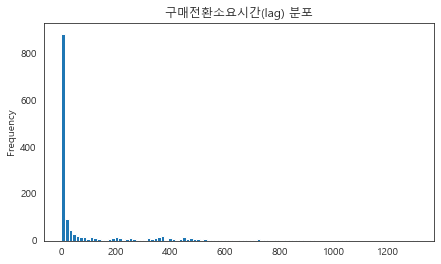

In [32]:
# 구매전환 소요시간 
# lag : 구매일 - 가입일 간 소요일수 계산
df['lag'] = (pd.to_datetime(df['order_date']) - pd.to_datetime(df['reg_date'])).dt.days

# lag_month : lag를 30일로 나누어 소요월 계산
df['lag_month'] = df['lag']/30
df['order_month'] = pd.to_datetime(df['order_date']).dt.month

# lag 분포 
df['lag'].plot(kind='hist',bins = 100, figsize=(7,4), title='구매전환소요시간(lag) 분포')
print(df.query('lag!=0').describe().lag.T)

# 가입일로부터 첫주문일까지 걸린 시간 lag_lvl에 4개 분류로 표기
# Sameday : 가입당일 / ~2Week : 가입 2주일 내/ ~3months :가입 3개월 내 / 3months : 가입 후 3개월 이후 전환 발생
cut_labels = ['Sameday', '~2weeks', '~3months', '3months+']
cut_bins = [-1, 1, 14, 90, 1304]
df['seg_lag'] = pd.cut(df['lag'], bins=cut_bins, labels=cut_labels)

##### seg_luxury 럭셔리 구매 비율
- `seg_luxury` (구매한 제품 건수 중 럭셔리 제품의 비율이 0.5 이상) : 럭셔리 선호 유저 vs 일반 유저

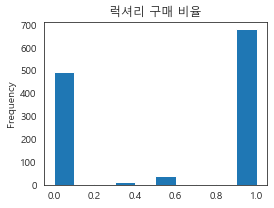

In [33]:
# 럭셔리 제품 비율 분포
(df.groupby('user').brandnm_luxury.sum()/df.groupby('user').order_date.count()).to_frame().plot.hist(figsize=(4,3),
                                                                                                     title='럭셔리 구매 비율',
                                                                                                     legend=False
                                                                                                    )
# 럭셔리 제품 비율 0.5 이상
luxury_user_list = (df.groupby('user').brandnm_luxury.sum()/ df.groupby('user').order_date.count()).to_frame().rename(columns={0:'pct_luxury'}).query('pct_luxury>=0.5').index.to_list()
# 럭셔리 유저 구분자 1, 0
df['seg_luxury']=np.where(df.user.isin(luxury_user_list),1,0)

### 전처리 3 :  테이블생성 
- 유저별 구매 정보 테이블 생성 df_user

In [34]:
# df_user 유저 기본 정보 테이블생성
df_user = df.groupby(['user','reg_date','reg_yearmonth','order_date','order_month','order_week','order_dayofweek'])['goodsnm'].count().to_frame().reset_index().rename(columns={'goodsnm':'order_count'}) 
ptype = df.pivot_table(index='user', columns='p_type',values= 'order_date',aggfunc='count').fillna(0).reset_index()
subtype = df.pivot_table(index='user', columns='sub_type',values= 'order_date',aggfunc='count').fillna(0).reset_index()
app = df.pivot_table(index='user', columns='app_yn',values= 'order_date',aggfunc='count').fillna(0).reset_index().rename(columns={'Y':'app'}) 
luxury = df.pivot_table(index='user',values= 'brandnm_luxury',aggfunc='sum').fillna(0).reset_index()

# merge
df_user = df_user.merge(ptype, how='left', on='user').merge(app, how='left', on='user').merge(luxury, how='left', on='user').merge(subtype, how='left', on='user').fillna(0)

# user segmentation (3.4) 정보 추가
# seg_new
df_user['seg_new'] = np.where(df_user.user.isin(new_list), 1, 0)
# seg_heavy
heavy_list=df_user.query('order_count>3').user.tolist()
df['seg_heavy']=np.where(df.user.isin(heavy_list),1,0)
df_user['seg_heavy']=np.where(df_user.user.isin(heavy_list),1,0)
# lag, seg_lag
df_user = df_user.merge(df.groupby('user')['lag'].min().reset_index().sort_values(by = 'lag', ascending = False).reset_index(drop=True), 
              on='user', how='left')
df_user['seg_lag'] = pd.cut(df_user['lag'], bins=cut_bins, labels=cut_labels)
# seg_luxury
df_user['seg_luxury'] = df_user['brandnm_luxury']/df_user['order_count']

df_user.head(2)

,user,reg_date,reg_yearmonth,order_date,order_month,order_week,order_dayofweek,order_count,4days,7days,...,드레스,상의,아우터,투피스,하의,seg_new,seg_heavy,lag,seg_lag,seg_luxury
0,a1100548,2020-05-16,2020-05,2021-03-31,3,13,2,2,2.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0,0,319,3months+,0.00
1,a1100887,2020-05-19,2020-05,2021-03-29,3,13,0,1,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0,0,314,3months+,1.00


In [35]:
# shape check
print(df.shape)
print(df_user.shape)
print(df.user.nunique())

(1471, 22)
(1234, 24)
1234


## EDA 
📃 **분석 수행시 설정한 기준 및 정의**
> **기존 컬럼 관련**
1. order_date는 유저의 `최초구매일자`로 고려하여 구매전환소요시간`lag`를 계산함
2. 본 데이터셋으로는 상품의 판매 시작 시기를 구분할 수 없으므로, 구매 상품 기반으로 트렌드를 파악함

📃 **세부 분석 내용**
1. 유저 그룹핑 기반 분석
2. 월별 트렌드 기반 분석

### 유저 그룹핑 기반 분석 

**목적**

개별 고객을 이해하고 동질 특성을 가진 유저그룹 기준으로 마케팅 및 서비스 방안 모색

**유저 그룹핑 기준**
1. seg_lag (주문시점-가입시점) : 가입일reg_date 구매일자 order_date간 차이 
2. seg_new (가입시점 2021) : 신규유저(1) vs 구유저(0)
3. seg_heavy (주문건수 4건 이상) : 헤비유저(1) vs 라이트유저(0)
4. seg_luxury (전체 구매 품목 수 중 럭셔리제품 비율 )

#### seg_new : 신규유저 vs 구유저

<AxesSubplot:title={'center':'신규 유저 vs 구유저 주문 수량'}, xlabel='reg_yearmonth'>

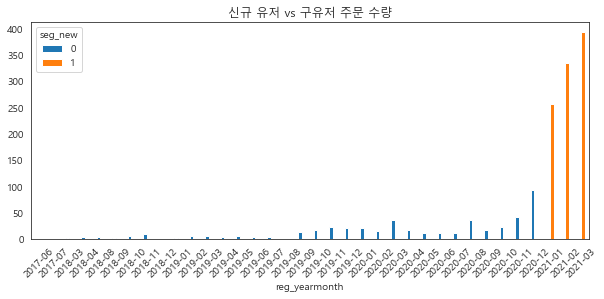

In [36]:
df_user.pivot_table(index='reg_yearmonth',columns='seg_new',
                   values='order_count', aggfunc='sum').plot.bar(rot=45, figsize=(10,4),
                                                                title ='신규 유저 vs 구유저 주문 수량')

- 첫 주문일자(order_date) 2021.1-3월인 유저 데이터로, 2021년에 가입한 신규유저에 집중되어있음


- `seg_new` 신규유저 vs 구유저 그룹핑 기반 분석시, 주문건수 대신 **비율** 중심으로 비교

In [37]:
# 브랜드별 신규유저 주문건수 & 구유저 주문건수(unique 값)
df_brandnm_신규유저 = (df.query("seg_new == 1").groupby(['brandnm'])['user'].count()/df.query("seg_new == 1")['user'].count()*100).to_frame().reset_index().\
                                rename(columns={'user':'신규유저주문(%)'}).sort_values(by='신규유저주문(%)', ascending=False)

df_brandnm_구유저= (df.query("seg_new == 0").groupby(['brandnm'])['user'].count()/df.query("seg_new == 0")['user'].count()*100).to_frame().reset_index().\
                                rename(columns={'user':'구유저주문(%)'}).sort_values(by='구유저주문(%)', ascending=False)


# df_brandnm_신규유저_주문건수 & df_brandnm_구유저_주문건수 병합 (inner join)
df_brandnm_주문건수 = df_brandnm_구유저.merge(df_brandnm_신규유저, how='inner', on='brandnm')

# 주문건수 비율 차이 계산
df_brandnm_주문건수['차이(%p)'] = (df_brandnm_주문건수['신규유저주문(%)'] - df_brandnm_주문건수['구유저주문(%)']) 

In [38]:
# 브랜드별 신규유저 주문건수 & 구유저 주문건수(unique 값)
df_sub_type_신규유저 = (df.query("seg_new == 1").groupby(['sub_type'])['user'].count()/df.query("seg_new == 1")['user'].count()*100).to_frame().reset_index().\
                                rename(columns={'user':'신규유저주문(%)'}).sort_values(by='신규유저주문(%)', ascending=False)

df_sub_type_구유저= (df.query("seg_new == 0").groupby(['sub_type'])['user'].count()/df.query("seg_new == 0")['user'].count()*100).to_frame().reset_index().\
                                rename(columns={'user':'구유저주문(%)'}).sort_values(by='구유저주문(%)', ascending=False)

# df_sub_type_신규유저_주문건수 & df_sub_type_구유저_주문건수 병합 (inner join)
df_sub_type_주문건수 = df_sub_type_구유저.merge(df_sub_type_신규유저, how='inner', on='sub_type')

# 주문건수 비율 차이 계산
df_sub_type_주문건수['차이(%p)'] = (df_sub_type_주문건수['신규유저주문(%)'] - df_sub_type_주문건수['구유저주문(%)']) 

In [39]:
# 브랜드별 신규유저 주문건수 & 구유저 주문건수(unique 값)
df_p_type_신규유저 = (df.query("seg_new == 1").groupby(['p_type'])['user'].count()/df.query("seg_new == 1")['user'].count()*100).to_frame().reset_index().\
                                rename(columns={'user':'신규유저주문(%)'}).sort_values(by='신규유저주문(%)', ascending=False)

df_p_type_구유저= (df.query("seg_new == 0").groupby(['p_type'])['user'].count()/df.query("seg_new == 0")['user'].count()*100).to_frame().reset_index().\
                                rename(columns={'user':'구유저주문(%)'}).sort_values(by='구유저주문(%)', ascending=False)

# df_p_type_신규유저_주문건수 & df_p_type_구유저_주문건수 병합 (inner join)
df_p_type_주문건수 = df_p_type_구유저.merge(df_p_type_신규유저, how='inner', on='p_type')

# 주문건수 비율 차이 계산
df_p_type_주문건수['차이(%p)'] = (df_p_type_주문건수['신규유저주문(%)'] - df_p_type_주문건수['구유저주문(%)']) 

In [40]:
# 브랜드별 신규유저 주문건수 & 구유저 주문건수(unique 값)
df_app_yn_신규유저 = (df.query("seg_new == 1").groupby(['app_yn'])['user'].count()/df.query("seg_new == 1")['user'].count()*100).to_frame().reset_index().\
                                rename(columns={'user':'신규유저주문(%)'}).sort_values(by='신규유저주문(%)', ascending=False)

df_app_yn_구유저= (df.query("seg_new == 0").groupby(['app_yn'])['user'].count()/df.query("seg_new == 0")['user'].count()*100).to_frame().reset_index().\
                                rename(columns={'user':'구유저주문(%)'}).sort_values(by='구유저주문(%)', ascending=False)

# df_app_yn_신규유저_주문건수 & df_app_yn_구유저_주문건수 병합 (inner join)
df_app_yn_주문건수 = df_app_yn_구유저.merge(df_app_yn_신규유저, how='inner', on='app_yn')

# 주문건수 비율 차이 계산
df_app_yn_주문건수['차이(%p)'] = (df_app_yn_주문건수['신규유저주문(%)'] - df_app_yn_주문건수['구유저주문(%)']) 


In [41]:
display(df_brandnm_주문건수.sort_values(by='차이(%p)', ascending=False).head(10).reset_index(drop=True).style.background_gradient('Blues'))
display(df_sub_type_주문건수.sort_values(by='차이(%p)', ascending=False).head(10).reset_index(drop=True).style.background_gradient('Blues'))
display(df_p_type_주문건수.sort_values(by='차이(%p)', ascending=False).head(10).reset_index(drop=True).style.background_gradient('Blues'))
display(df_app_yn_주문건수.sort_values(by='차이(%p)', ascending=False).head(10).reset_index(drop=True).style.background_gradient('Blues'))

,brandnm,구유저주문(%),신규유저주문(%),차이(%p)
0,Gucci,13.402062,17.038540,3.636478
1,Saint Laurent,4.123711,6.693712,2.570001
2,Louis Vuitton,3.711340,6.186613,2.475272
3,Chanel,5.360825,6.592292,1.231467
4,Celine,1.237113,2.231237,0.994124
5,Fendi,1.649485,2.231237,0.581753
6,Theory,0.206186,0.709939,0.503754
7,Fayewoo,0.206186,0.608519,0.402334
8,Michaa,0.618557,1.014199,0.395642
9,Comme des Garcons,0.206186,0.405680,0.199494


,sub_type,구유저주문(%),신규유저주문(%),차이(%p)
0,가방,38.556701,51.217039,12.660338
1,하의,4.123711,3.853955,-0.269756
2,드레스,18.144330,17.545639,-0.598691
3,투피스,2.474227,1.724138,-0.750089
4,상의,13.195876,10.141988,-3.053888
5,아우터,23.505155,15.517241,-7.987913


,p_type,구유저주문(%),신규유저주문(%),차이(%p)
0,7days,33.195876,42.190669,8.994793
1,4days,66.804124,57.809331,-8.994793


,app_yn,구유저주문(%),신규유저주문(%),차이(%p)
0,0,7.422680,14.198783,6.776103
1,1,92.577320,85.801217,-6.776103


전체 구매에서 차지하는 퍼센티지 계산 후 그룹간 차이를 파악함

**📍 (Insights)**

>**브랜드 선호도**
>- 구찌, 생로랑, 루이비통, 샤넬, 셀린, 펜디 순으로 비율차이 큼 
>- 신규유저에게서 명품 브랜드 수요가 증가하는 양상

>**sub_type 선호도**
>- 가방 카테고리에서 월등한 차이
>- 구유저의 아우터, 드레스 주문 (%) 높음

>**p_type 선호도**
>- 신규유저 그룹에서는 큰 차이를 보이지 않으나, 구유저 그룹에서는 4일권 선호

>**앱이용여부**
>- 두 그룹 모두 앱이용 압도적



**💡 (Conclusion)**

>**2021년 가입자인 신규유저 그룹 타겟팅 전략**
>1. 명품브랜드 & 가방 집중 
>2. 7일권 이용시 할인
>3. 앱 설치시 쿠폰 이벤트

>**2021년 이전 가입자인 구유저 그룹 타겟팅 전략**
>1. 명품브랜드 & 의류 집중
>2. 가입시기 오래된 고객들에게 앱푸시 광고 
  (ex. 2018년 8월 8일에 가입하신 OO님! 잊지 않고 방문해주시라고 5000원 할인 쿠폰을 드립니다!)



#### seg_lag : sameday 유저 ~ 3months+유저

- 가입일reg_date 구매일자order_date간 차이를 구매전환소요시간 lag라 정의
- seg_lag('Sameday', '~2weeks', '~3months', '3months+') 유저 그룹 생성
- seg_new(신규유저, 구유저) 와 겹치는 그룹핑 존재함

**하기 4개 기준으로 그룹핑**

>1) Sameday: 가입일에 바로 전환이 발생한 user로 서비스 필요도가 높은 고객으로 추측

>2) 2weeks: 가입 후 2주 이내 전환이 발생한 user로 서비스가 필요했으나, 원하는 이용 시점이 있었던 고객으로 추측

>3) 3months: 가입 후 6달 이내 전환이 발생한 user로 서비스가 필요했던 잠재고객이었던 것으로 추측

>4) 3months+: 가입 후 3달 이후 전환이 발생한 user로 리마인드 메일과 같은 특정 조건에 의해 서비스의 필요를 상기한 고객으로 추측

<AxesSubplot:title={'center':'구매 전환 소요시간 그룹(seg_lag)별 유저 수'}, xlabel='seg_lag'>

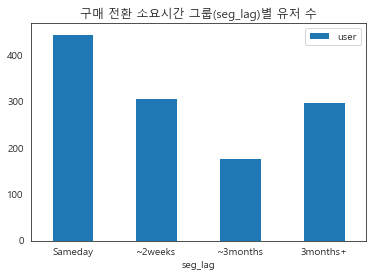

In [42]:
df_user.pivot_table(index='seg_lag', values='user',
                    aggfunc='count').reset_index().plot(kind='bar', x='seg_lag',
                                                       rot=0, figsize=(6,4),
                                                   title='구매 전환 소요시간 그룹(seg_lag)별 유저 수')

Text(0.5, 1.0, '구매수량(x)과 구매전환소요시간(y)')

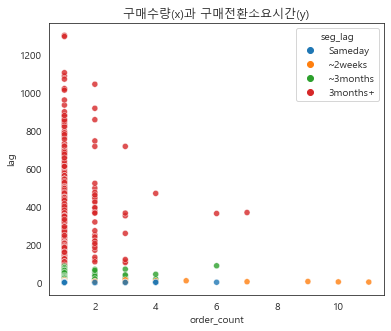

In [43]:
plt.figure(figsize=(6,5))
sns.scatterplot(data=df_user, y='lag', x='order_count', 
                hue='seg_lag', alpha =0.8)
plt.title('구매수량(x)과 구매전환소요시간(y)')

(1)
- `Sameday` 가입당일 구매 유저 수가 제일 많음 
- `3months+` 구매전환소요시간 3개월이상인 그룹도 유저 수가 많음

(2)
- `3months+` 유저 대부분 1-2 건, 유저 주문 건수 많은 경우 전환소요시간 짧은 그룹

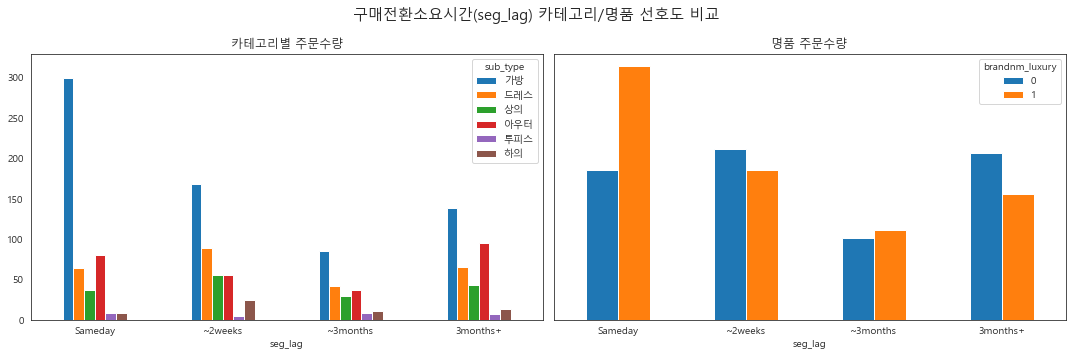

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5), sharey=True)
fig.suptitle('구매전환소요시간(seg_lag) 카테고리/명품 선호도 비교', fontsize=15)
df.pivot_table(index='seg_lag', columns='sub_type',
               values='order_date', aggfunc='count').plot.bar(rot=0, title= '카테고리별 주문수량', ax=axes[0])
df.pivot_table(index='seg_lag', columns='brandnm_luxury',
               values='order_date', aggfunc='count').plot.bar(rot=0, title='명품 주문수량', ax=axes[1])
fig.tight_layout()
fig.subplots_adjust(top=0.85)

(1)
- `3months+`구매전환소요시간 3개월이상인 그룹 아우터 비중 높은 편 (구유저)

(2)
- `Sameday` 가입당일 구매 그룹 명품 선호도 높음 (신규유저)

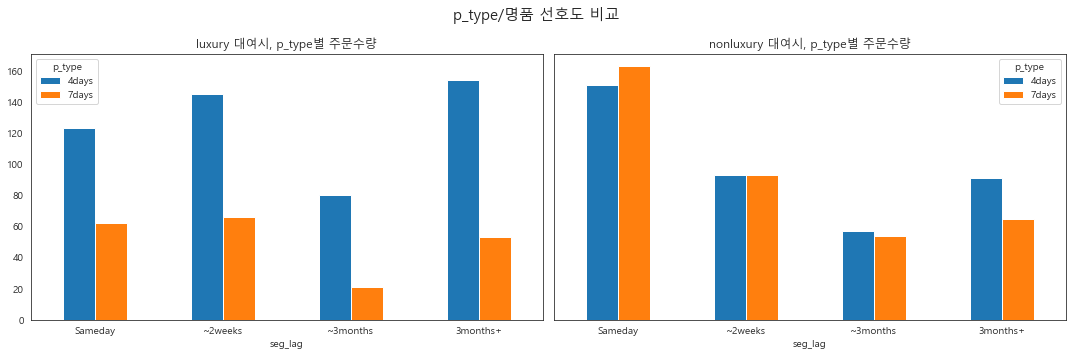

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5), sharey=True)
fig.suptitle('p_type/명품 선호도 비교', fontsize=15)
df.query('brandnm_luxury==0').pivot_table(index='seg_lag', columns='p_type',
               values='order_date', aggfunc='count').plot.bar(rot=0, 
                                                              title='luxury 대여시, p_type별 주문수량', ax=axes[0])

df.query('brandnm_luxury==1').pivot_table(index='seg_lag', columns='p_type',
               values='order_date', aggfunc='count').plot.bar(rot=0,
                                                              title='nonluxury 대여시, p_type별 주문수량', ax=axes[1])
fig.tight_layout()
fig.subplots_adjust(top=0.85)

(1)
- luxury 대여시, 전체 그룹에서 4일권 선호
- nonluxury 대여시, 전체 그룹에서 4/7일권 선호 차이 크지 않음

(2)
- `Sameday` 가입당일 구매 그룹 명품 선호도 높음 (seg_new와 동일)


**📍(Insights)**

>**브랜드 선호도**
>- `Sameday` 가입당일 구매 그룹 명품 선호도 높음 (`seg_new==1` 신규유저와 동일)

>**sub_type 선호도**
>- `3months+` 구매전환소요시간 3개월이상인 그룹 아우터 비중 높은 편

>**p_type 선호도**
>- luxury 대여시, 전체 그룹에서 4일권 선호
>- nonluxury 대여시, 전체 그룹에서 4/7일권 선호 차이 크지 않음

**💡(Conclusion)**
>- `~3month` 구매전환소요시간 2주이상 3개월이내 그룹 유저 수가 적으니, 가입일 2주이내 구매로 유도하는 전략
>- 제품이 `luxury/nonluxury` p_type 선호 양상이 달라지므로 제품의 `brandnm_luxury`럭셔리 여부에 따라 전략을 다르게 취해야함

#### seg_heavy

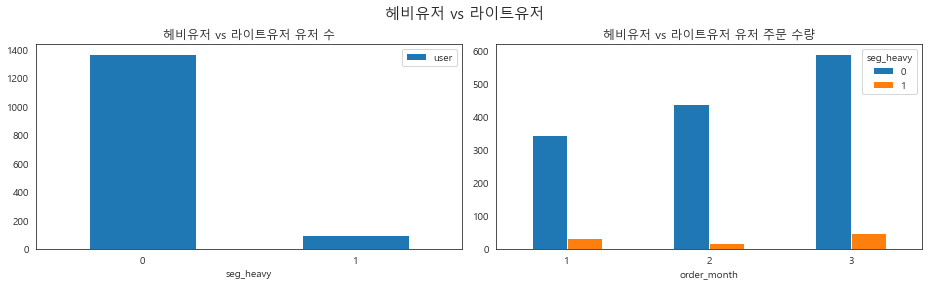

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(13,4))
fig.suptitle('헤비유저 vs 라이트유저', fontsize=15)

df.pivot_table(index='seg_heavy',
                   values='user', aggfunc='count').plot.bar(ax=axes[0],
                                                                 rot=0,
                                                                title ='헤비유저 vs 라이트유저 유저 수')
df_user.pivot_table(index='order_month',columns='seg_heavy',
                   values='order_count', aggfunc='sum').plot.bar(ax=axes[1],
                                                                 rot=0, 
                                                                title ='헤비유저 vs 라이트유저 유저 주문 수량')

fig.tight_layout()
fig.subplots_adjust(top=0.85)

(1)
- 라이트유저 3건 이하 구매 유저가 대부분

(2)
- 헤비유저 1>2>3월 증가 양상

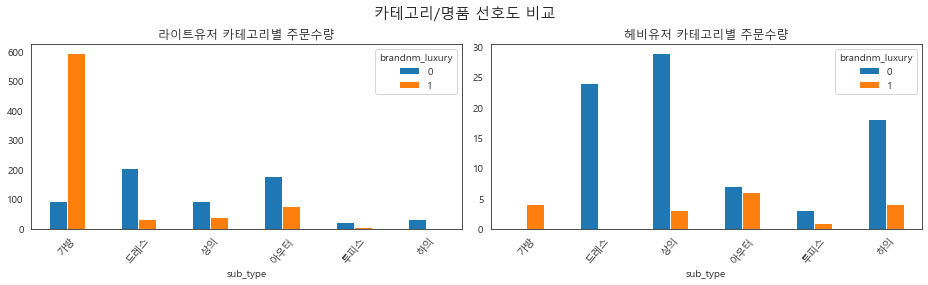

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(13,4))
fig.suptitle('카테고리/명품 선호도 비교', fontsize=15)
df.query('seg_heavy==0').pivot_table(index='sub_type', columns='brandnm_luxury',
               values='order_date', aggfunc='count').plot.bar(rot=50, title='라이트유저 카테고리별 주문수량', ax=axes[0])
df.query('seg_heavy==1').pivot_table(index='sub_type', columns='brandnm_luxury',
               values='order_date', aggfunc='count').plot.bar(rot=50, title='헤비유저 카테고리별 주문수량', ax=axes[1])
fig.tight_layout()
fig.subplots_adjust(top=0.85)

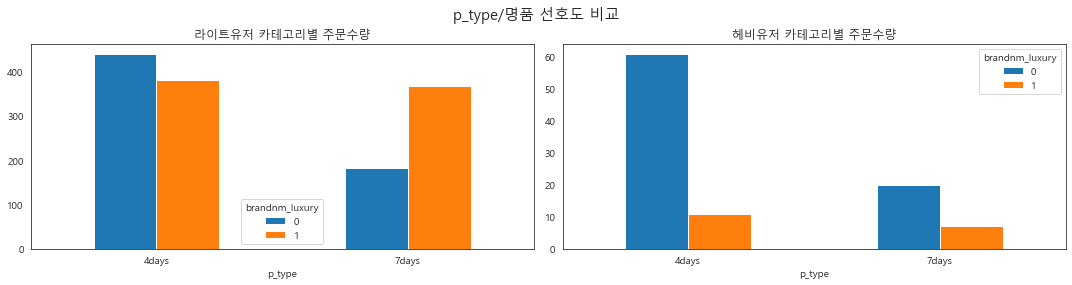

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,4))
fig.suptitle('p_type/명품 선호도 비교', fontsize=15)
df.query('seg_heavy==0').pivot_table(index='p_type', columns='brandnm_luxury',
               values='order_date', aggfunc='count').plot.bar(rot=0, title='라이트유저 카테고리별 주문수량', ax=axes[0])

df.query('seg_heavy==1').pivot_table(index='p_type', columns='brandnm_luxury',
               values='order_date', aggfunc='count').plot.bar(rot=0, title='헤비유저 카테고리별 주문수량', ax=axes[1])
fig.tight_layout()
fig.subplots_adjust(top=0.85)

(1)
- 라이트 유저 명품 가방 집중 뚜렷


(2)
- 라이트유저 명품대여시 7일권 선호 
- 헤비유저 4일권 집중 양상 뚜렷

(수정 필요)
> - ex 논헤비유저의 명품 가방 선호 & 명품인경우 7일권 주문수량 많음 :: 명품 가방 주문시 7일권 할인이벤트 진행
> - ex 

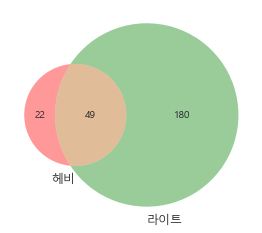

In [49]:
# 헤비 유저 vs 라이트 유저 주문 브랜드 차이 
plt.figure(figsize=(5,4))
venn2([set(df.query('seg_heavy==1')['brandnm'].tolist()),set(df.query('seg_heavy==0')['brandnm'].tolist())],
     set_labels = ('헤비','라이트'))
plt.show()

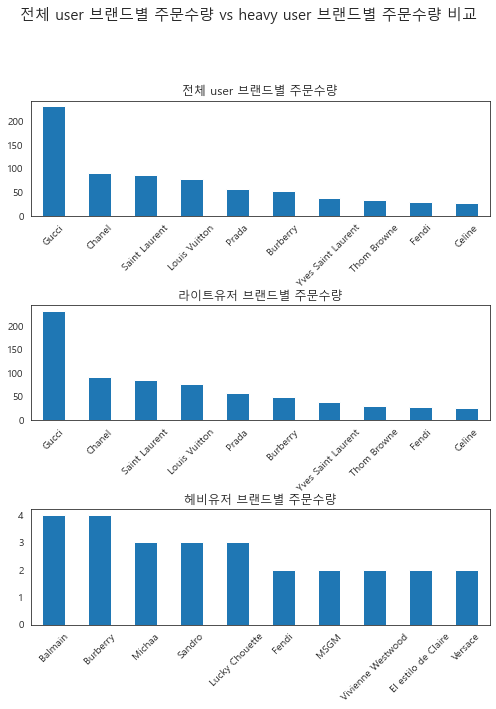

In [50]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(7,10))
fig.suptitle('전체 user 브랜드별 주문수량 vs heavy user 브랜드별 주문수량 비교', fontsize=15)
df.brandnm.value_counts().sort_values(ascending=False).head(10).plot.bar(rot=45, title='전체 user 브랜드별 주문수량', ax=axes[0])
df.query('seg_heavy==0').brandnm.value_counts().sort_values(ascending=False).head(10).plot.bar(rot=45, title='라이트유저 브랜드별 주문수량', ax=axes[1])
df.query('seg_heavy==1').brandnm.value_counts().sort_values(ascending=False).head(10).plot.bar(rot=45, title='헤비유저 브랜드별 주문수량', ax=axes[2])

fig.tight_layout()
fig.subplots_adjust(top=0.85)

22
Versace             2
Musinsa standard    2
BCBG Max Azria      2
Bourie              1
Moia                1
Bar Bour            1
Wonder Style        1
Lafudge Store       1
Reiss               1
System homme        1
Name: brandnm, dtype: int64


<AxesSubplot:>

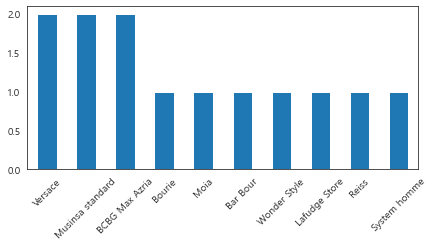

In [51]:
heavy_brand_list = list(set(df.query('seg_heavy==1')['brandnm'].tolist())-set(df.query('seg_heavy==0')['brandnm'].tolist()))
print(len(heavy_brand_list))
print(df[df.brandnm.isin(heavy_brand_list)].brandnm.value_counts().sort_values(ascending=False).head(10))
df[df.brandnm.isin(heavy_brand_list)].brandnm.value_counts().sort_values(ascending=False).head(10).plot.bar(rot=45, figsize=(7,3))

인사이트 작성 필요

In [52]:
# 브랜드별 헤비유저 주문건수 & 라이트유저 주문건수(unique 값)
df_sub_type_헤비유저 = (df.query("seg_heavy == 1").groupby(['sub_type'])['user'].count()/df.query("seg_heavy == 1")['user'].count()*100).to_frame().reset_index().\
                                rename(columns={'user':'헤비유저주문(%)'}).sort_values(by='헤비유저주문(%)', ascending=False)

df_sub_type_라이트유저= (df.query("seg_heavy == 0").groupby(['sub_type'])['user'].count()/df.query("seg_heavy == 0")['user'].count()*100).to_frame().reset_index().\
                                rename(columns={'user':'라이트유저주문(%)'}).sort_values(by='라이트유저주문(%)', ascending=False)

# df_sub_type_헤비유저_주문건수 & df_sub_type_라이트유저_주문건수 병합 (inner join)
df_sub_type_주문건수 = df_sub_type_라이트유저.merge(df_sub_type_헤비유저, how='inner', on='sub_type')
df_sub_type_주문건수.fillna(0, inplace=True)

# 주문건수 비율 차이 계산
df_sub_type_주문건수['차이(%p)'] = (df_sub_type_주문건수['헤비유저주문(%)'] - df_sub_type_주문건수['라이트유저주문(%)']) 

In [53]:
# 브랜드별 헤비유저 주문건수 & 라이트유저 주문건수(unique 값)
df_p_type_헤비유저 = (df.query("seg_heavy == 1").groupby(['p_type'])['user'].count()/df.query("seg_heavy == 1")['user'].count()*100).to_frame().reset_index().\
                                rename(columns={'user':'헤비유저주문(%)'}).sort_values(by='헤비유저주문(%)', ascending=False)

df_p_type_라이트유저= (df.query("seg_heavy == 0").groupby(['p_type'])['user'].count()/df.query("seg_heavy == 0")['user'].count()*100).to_frame().reset_index().\
                                rename(columns={'user':'라이트유저주문(%)'}).sort_values(by='라이트유저주문(%)', ascending=False)

# df_p_type_헤비유저_주문건수 & df_p_type_라이트유저_주문건수 병합 (inner join)
df_p_type_주문건수 = df_p_type_라이트유저.merge(df_p_type_헤비유저, how='inner', on='p_type')
df_p_type_주문건수.fillna(0, inplace=True)

# 주문건수 비율 차이 계산
df_p_type_주문건수['차이(%p)'] = (df_p_type_주문건수['헤비유저주문(%)'] - df_p_type_주문건수['라이트유저주문(%)']) 

In [54]:
# 브랜드별 헤비 주문건수 & 라이트유저 주문건수(unique 값)
df_app_yn_헤비 = (df.query("seg_heavy == 1").groupby(['app_yn'])['user'].count()/df.query("seg_heavy == 1")['user'].count()*100).to_frame().reset_index().\
                                rename(columns={'user':'헤비주문(%)'}).sort_values(by='헤비주문(%)', ascending=False)

df_app_yn_라이트유저= (df.query("seg_heavy == 0").groupby(['app_yn'])['user'].count()/df.query("seg_heavy == 0")['user'].count()*100).to_frame().reset_index().\
                                rename(columns={'user':'라이트유저주문(%)'}).sort_values(by='라이트유저주문(%)', ascending=False)

# df_app_yn_헤비_주문건수 & df_app_yn_라이트유저_주문건수 병합 (inner join)
df_app_yn_주문건수 = df_app_yn_라이트유저.merge(df_app_yn_헤비, how='inner', on='app_yn')
df_app_yn_주문건수.fillna(0, inplace=True)

# 주문건수 비율 차이 계산
df_app_yn_주문건수['차이(%p)'] = (df_app_yn_주문건수['헤비주문(%)'] - df_app_yn_주문건수['라이트유저주문(%)']) 


In [55]:
display(df_sub_type_주문건수.sort_values(by='차이(%p)', ascending=False).head(10).reset_index(drop=True).style.background_gradient('Blues'))
display(df_p_type_주문건수.sort_values(by='차이(%p)', ascending=False).head(10).reset_index(drop=True).style.background_gradient('Blues'))
display(df_app_yn_주문건수.sort_values(by='차이(%p)', ascending=False).head(10).reset_index(drop=True).style.background_gradient('Blues'))

,sub_type,라이트유저주문(%),헤비유저주문(%),차이(%p)
0,상의,9.620991,32.323232,22.702241
1,하의,2.623907,22.222222,19.598316
2,드레스,17.274052,24.242424,6.968372
3,투피스,1.822157,4.040404,2.218247
4,아우터,18.513120,13.131313,-5.381806
5,가방,50.145773,4.040404,-46.105369


,p_type,라이트유저주문(%),헤비유저주문(%),차이(%p)
0,4days,59.912536,72.727273,12.814736
1,7days,40.087464,27.272727,-12.814736


,app_yn,라이트유저주문(%),헤비주문(%),차이(%p)
0,0,10.568513,31.313131,20.744618
1,1,89.431487,68.686869,-20.744618


**📍 (Insights)**

>**sub_type 선호도**
>- 헤비유저 그룹 의류(상의 하의 드레스)비중 높음
>- 라이트유저 그룹 가방 비중 50% 이상

>**p_type 선호도**
>- 헤비유저 4일권 선호 양상 뚜렷

>**앱이용여부**
>- 라이트 유저 앱이용 압도적


**💡 (Conclusion)**

>**헤비유저 그룹 타겟팅 전략**
>**라이트유저 그룹 타겟팅 전략**



#### seg_luxury

In [56]:
# 브랜드별 럭셔리유저 주문건수 & 일반유저 주문건수(unique 값)
df_sub_type_럭셔리유저 = (df.query("seg_luxury == 1").groupby(['sub_type'])['user'].count()/df.query("seg_luxury == 1")['user'].count()*100).to_frame().reset_index().\
                                rename(columns={'user':'럭셔리유저주문(%)'}).sort_values(by='럭셔리유저주문(%)', ascending=False)

df_sub_type_일반유저= (df.query("seg_luxury == 0").groupby(['sub_type'])['user'].count()/df.query("seg_luxury == 0")['user'].count()*100).to_frame().reset_index().\
                                rename(columns={'user':'일반유저주문(%)'}).sort_values(by='일반유저주문(%)', ascending=False)

# df_sub_type_럭셔리유저_주문건수 & df_sub_type_일반유저_주문건수 병합 (inner join)
df_sub_type_주문건수 = df_sub_type_일반유저.merge(df_sub_type_럭셔리유저, how='inner', on='sub_type')
df_sub_type_주문건수.fillna(0, inplace=True)

# 주문건수 비율 차이 계산
df_sub_type_주문건수['차이(%p)'] = (df_sub_type_주문건수['럭셔리유저주문(%)'] - df_sub_type_주문건수['일반유저주문(%)']) 

In [57]:
# 브랜드별 럭셔리유저 주문건수 & 일반유저 주문건수(unique 값)
df_p_type_럭셔리유저 = (df.query("seg_luxury == 1").groupby(['p_type'])['user'].count()/df.query("seg_luxury == 1")['user'].count()*100).to_frame().reset_index().\
                                rename(columns={'user':'럭셔리유저주문(%)'}).sort_values(by='럭셔리유저주문(%)', ascending=False)

df_p_type_일반유저= (df.query("seg_luxury == 0").groupby(['p_type'])['user'].count()/df.query("seg_luxury == 0")['user'].count()*100).to_frame().reset_index().\
                                rename(columns={'user':'일반유저주문(%)'}).sort_values(by='일반유저주문(%)', ascending=False)

# df_p_type_럭셔리유저_주문건수 & df_p_type_일반유저_주문건수 병합 (inner join)
df_p_type_주문건수 = df_p_type_일반유저.merge(df_p_type_럭셔리유저, how='inner', on='p_type')
df_p_type_주문건수.fillna(0, inplace=True)

# 주문건수 비율 차이 계산
df_p_type_주문건수['차이(%p)'] = (df_p_type_주문건수['럭셔리유저주문(%)'] - df_p_type_주문건수['일반유저주문(%)']) 

In [58]:
# 브랜드별 럭서리유저 주문건수 & 일반유저 주문건수(unique 값)
df_app_yn_럭서리유저 = (df.query("seg_luxury == 1").groupby(['app_yn'])['user'].count()/df.query("seg_luxury == 1")['user'].count()*100).to_frame().reset_index().\
                                rename(columns={'user':'럭서리유저주문(%)'}).sort_values(by='럭서리유저주문(%)', ascending=False)

df_app_yn_일반유저= (df.query("seg_luxury == 0").groupby(['app_yn'])['user'].count()/df.query("seg_luxury == 0")['user'].count()*100).to_frame().reset_index().\
                                rename(columns={'user':'일반유저주문(%)'}).sort_values(by='일반유저주문(%)', ascending=False)

# df_app_yn_럭서리유저_주문건수 & df_app_yn_일반유저_주문건수 병합 (inner join)
df_app_yn_주문건수 = df_app_yn_일반유저.merge(df_app_yn_럭서리유저, how='inner', on='app_yn')
df_app_yn_주문건수.fillna(0, inplace=True)

# 주문건수 비율 차이 계산
df_app_yn_주문건수['차이(%p)'] = (df_app_yn_주문건수['럭서리유저주문(%)'] - df_app_yn_주문건수['일반유저주문(%)']) 


In [59]:
display(df_sub_type_주문건수.sort_values(by='차이(%p)', ascending=False).head(10).reset_index(drop=True).style.background_gradient('Blues'))
display(df_p_type_주문건수.sort_values(by='차이(%p)', ascending=False).head(10).reset_index(drop=True).style.background_gradient('Blues'))
display(df_app_yn_주문건수.sort_values(by='차이(%p)', ascending=False).head(10).reset_index(drop=True).style.background_gradient('Blues'))

,sub_type,일반유저주문(%),럭셔리유저주문(%),차이(%p)
0,가방,15.044248,74.401009,59.356761
1,투피스,3.244838,0.882724,-2.362114
2,하의,7.522124,0.882724,-6.639400
3,상의,17.404130,5.800757,-11.603373
4,아우터,24.483776,12.736444,-11.747332
5,드레스,32.300885,5.296343,-27.004542


,p_type,일반유저주문(%),럭셔리유저주문(%),차이(%p)
0,7days,28.318584,48.549811,20.231227
1,4days,71.681416,51.450189,-20.231227


,app_yn,일반유저주문(%),럭서리유저주문(%),차이(%p)
0,1,85.840708,89.911728,4.071020
1,0,14.159292,10.088272,-4.071020


인사이트 작성 필요 

#### 연관분석
✏️ 가설 설정 : 특정 유저 그룹에 많이 대여되는 브랜드 세트가 있지 않을까?
- http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/
- https://wotres.tistory.com/entry/Association-Rule-%EC%97%B0%EA%B4%80%EC%84%B1-%EB%B6%84%EC%84%9D-in-python
- 지지도 x, y가 함께 발생할 확률 
- 향상도 1 : 품목간 관계 없음, >1 긍정 관계, <1 부정관계
- 신뢰도 : 조건부 확률 x > y

In [60]:
#! pip install mlxtend
# 인코딩용
from mlxtend.preprocessing import TransactionEncoder
# 연관분석 
from mlxtend.frequent_patterns import apriori
te=TransactionEncoder() # 객체 생성

In [61]:
# 연관규칙 리스트 생성
def toList(x):
    return list(set(x))
# 같은 주에 구매된 브랜드 리스트 & 2개 이상 필터링
df_asso=df.groupby('seg_lag').brandnm.apply(lambda x : toList(x)).reset_index()
df_asso['len'] = df_asso.brandnm.apply(lambda x: len(x)>=2)
df_asso.head(5)

,seg_lag,brandnm,len
0,Sameday,"[Burberry London, Bottega Veneta, Gucci, Arman...",True
1,~2weeks,"[Rebecca Minkoff, Burberry London, Musinsa sta...",True
2,~3months,"[Burberry London, Bottega Veneta, Gucci, Chi C...",True
3,3months+,"[Burberry London, Bottega Veneta, Helmut Lang,...",True


In [62]:
asso_list = list(df_asso.brandnm)

In [63]:
#asso_list[:1]

In [64]:
asso_list_encoded = te.fit(asso_list).transform(asso_list)
# one hot encoding
asso_list_encoded=asso_list_encoded.astype("int")
df_asso_encoded = pd.DataFrame(asso_list_encoded, columns=te.columns_)

In [65]:
df_asso_encoded.columns

Index(['& Other Stories', 'A BY A', 'A.P.C.', 'ACNE STUDIOS', 'Adidas',
       'Adidas X Stella Mccartney', 'Akro', 'Alexander Mcqueen',
       'Alexander Wang', 'Alice & Olivia',
       ...
       'Wai Kei', 'Wonder Style', 'Your Name Here', 'Yves Saint Laurent',
       'Zadig & Voltaire', 'Zooc', 'cecilie bahnsen', 'khrisjoy', 'roajeu',
       'thom browne'],
      dtype='object', length=251)

In [66]:
df_asso_encoded.head(5)

,& Other Stories,A BY A,A.P.C.,ACNE STUDIOS,Adidas,Adidas X Stella Mccartney,Akro,Alexander Mcqueen,Alexander Wang,Alice & Olivia,...,Wai Kei,Wonder Style,Your Name Here,Yves Saint Laurent,Zadig & Voltaire,Zooc,cecilie bahnsen,khrisjoy,roajeu,thom browne
0,1,0,1,1,0,0,0,1,0,0,...,1,0,0,1,1,0,0,0,0,1
1,1,1,0,0,0,0,0,0,1,1,...,0,1,1,1,0,1,1,0,1,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,0,1,1,1,1,1,1,0,0,...,0,0,0,1,0,0,0,1,0,0


In [67]:
#apriori(df_asso_encoded, min_support=0.7, use_colnames=True)

In [68]:
#df_frequent_itemsets= apriori(df_asso_encoded, min_support=0.7, use_colnames=True)
#df_frequent_itemsets['len']=df_frequent_itemsets['itemsets'].apply(lambda x : len(x))
#df_frequent_itemsets[df_frequent_itemsets['len']>=2]

In [69]:
#association_rules(df_frequent_itemsets, metric='support', min_threshold=0.9)

## 월별 데이터 분석 
- order_date를 기반으로 1,2,3월 구매 건을 나누어 세부내용 분석
- 분석대상 : 선호 브랜드, 선호 제품, 유저별 대여제품 건수, 주문요일, 이용권, 제품카테고리, 앱사용여부

In [70]:
df.loc[(df['app_yn'] == 1),'app_yn'] = 'Y'
df.loc[(df['app_yn'] == 0),'app_yn'] = 'N'

In [71]:
df_monthly = df.groupby('order_month')['goodsnm'].count().reset_index().rename(columns = {'goodsnm' : 'count'})
df_monthly

,order_month,count
0,1,377
1,2,455
2,3,639


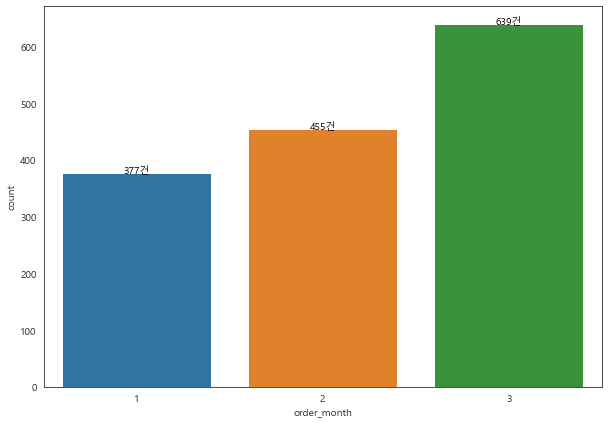

In [72]:
# 월별 대여건수는 성장추세
g = sns.barplot(x='order_month',y='count',data=df_monthly)
for index, row in df_monthly.iterrows():
    g.text(x = row.name, y = row['count'], s = str(row['count']) + str('건'), color='black', ha="center")

### 1) 월별 선호 브랜드

In [73]:
# order_month, brandnm으로 groupby
df_monthly_brand = df.groupby(['order_month', 'brandnm'])['p_type'].count().reset_index().sort_values(
    by = 'p_type', ascending = False).rename(columns = {'p_type' : 'count'})
df_monthly_brand

,order_month,brandnm,count
299,3,Gucci,101
169,2,Gucci,76
43,1,Gucci,56
272,3,Chanel,39
316,3,Louis Vuitton,39
...,...,...,...
238,2,Vw vera Wang,1
239,2,Wai Kei,1
241,2,cecilie bahnsen,1
242,2,thom browne,1


In [74]:
# 월별 대여 건수가 2 이상이었던 인기 브랜드 확인
df_jan = df_monthly_brand[df_monthly_brand['order_month'] == 1]
df_feb = df_monthly_brand[df_monthly_brand['order_month'] == 2]
df_mar = df_monthly_brand[df_monthly_brand['order_month'] == 3]

df_jan['pct'] = df_jan['count'] / np.sum(df_jan['count']) * 100
df_feb['pct'] = df_feb['count'] / np.sum(df_feb['count']) * 100
df_mar['pct'] = df_mar['count'] / np.sum(df_mar['count']) * 100

df_jan_top = df_jan[df_jan['count'] != 1]
df_feb_top = df_feb[df_feb['count'] != 1]
df_mar_top = df_mar[df_mar['count'] != 1]

In [75]:
# 1월 인기 브랜드
df_jan_top.head()

,order_month,brandnm,count,pct
43,1,Gucci,56,14.85
91,1,Saint Laurent,21,5.57
86,1,Prada,20,5.31
20,1,Chanel,15,3.98
59,1,Louis Vuitton,13,3.45


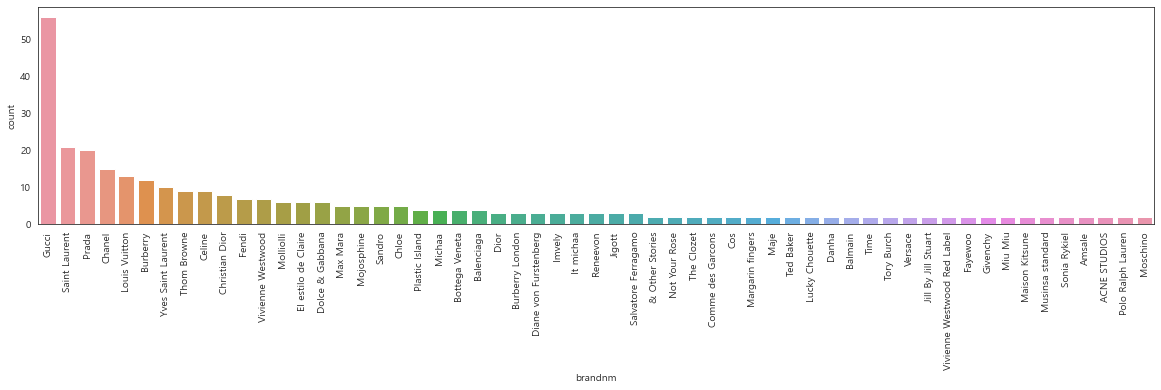

In [76]:
# 1월 인기 브랜드
plt.figure(figsize = (20,4))
plt.xticks(rotation = 90)
g = sns.barplot(x='brandnm',y='count',data=df_jan_top)

In [77]:
# 2월 인기 브랜드
df_feb_top.head()

,order_month,brandnm,count,pct
169,2,Gucci,76,16.70
145,2,Chanel,37,8.13
218,2,Saint Laurent,31,6.81
182,2,Louis Vuitton,27,5.93
207,2,Prada,23,5.05


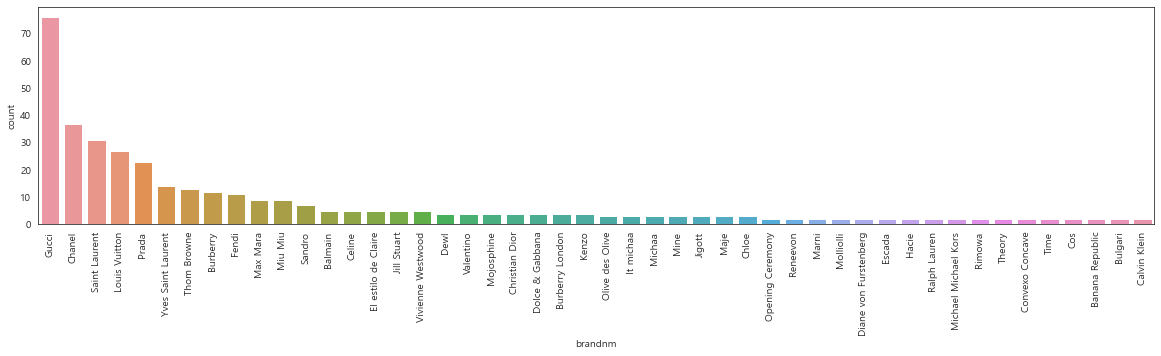

In [78]:
# 2월 인기 브랜드
plt.figure(figsize = (20,4))
plt.xticks(rotation = 90)
g = sns.barplot(x='brandnm',y='count',data=df_feb_top)

In [79]:
# 3월 인기 브랜드
df_mar_top.head()

,order_month,brandnm,count,pct
299,3,Gucci,101,15.81
272,3,Chanel,39,6.10
316,3,Louis Vuitton,39,6.10
364,3,Saint Laurent,34,5.32
265,3,Burberry,29,4.54


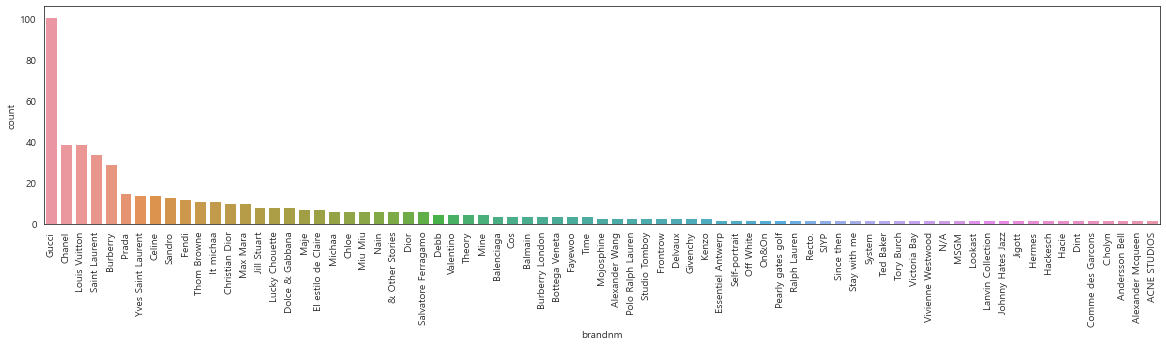

In [80]:
# 3월 인기 브랜드
plt.figure(figsize = (20,4))
plt.xticks(rotation = 90)
g = sns.barplot(x='brandnm',y='count',data=df_mar_top)

In [81]:
print(f'1월에 2건 이상 대여된 브랜드 : {df_jan_top.shape[0]}개')
print(f'2월에 2건 이상 대여된 브랜드 : {df_feb_top.shape[0]}개')
print(f'3월에 2건 이상 대여된 브랜드 : {df_mar_top.shape[0]}개')

1월에 2건 이상 대여된 브랜드 : 57개
2월에 2건 이상 대여된 브랜드 : 48개
3월에 2건 이상 대여된 브랜드 : 75개


⚡인사이트⚡ 
- 매월 Gucci가 전체 대여건수의 15~17%를 차지하며 압도적인 1위
- Top 5에 Chanel, Louis Vuitton, Saint Laurent는 항상 포함, Burberry, Prada는 대체로 포함
- 대여 건수가 2 이상이었던 브랜드 개수는 1->2월에 줄어들었다가 3월에 대폭 늘어남
- 클로젯셰어에서 대여되는 브랜드 종류가 다양해지고 있다고 유추해볼 수 있음

⚡마케팅 제안⚡
- Gucci가 압도적인 브랜드 지지를 받고 있으므로 셰어러들이 Gucci 제품을 더 공유 할 수 있게 하는 전략 필요
- Gucci제품과 함께 많이 사용한 물품 분석 및 활용

### 2) 월별 선호 제품

In [82]:
# order_month, goodsnm으로 groupby
df_monthly_goods = df.groupby(['order_month', 'goodsnm', 'sub_type'])['p_type'].count().reset_index().sort_values(
    by = 'p_type', ascending = False).rename(columns = {'p_type' : 'count'})
df_monthly_goods

,order_month,goodsnm,sub_type,count
861,3,chevron quilted cross bag black,가방,9
867,3,classic clutch black,가방,7
93,1,chevron quilted cross bag black,가방,7
446,2,chevron quilted cross bag black,가방,7
790,3,boy chanel clutch black,가방,6
...,...,...,...,...
426,2,button stripe pattern shirts mint,상의,1
428,2,button stripe pattern sweater mustard,상의,1
429,2,button stripe pattern wool cardigan black,아우터,1
430,2,cabas monogram two way bag beige,가방,1


In [83]:
# 월별 대여 건수가 2 이상이었던 인기 제품 확인
df_jan = df_monthly_goods[df_monthly_goods['order_month'] == 1]
df_feb = df_monthly_goods[df_monthly_goods['order_month'] == 2]
df_mar = df_monthly_goods[df_monthly_goods['order_month'] == 3]

df_jan['pct'] = df_jan['count'] / np.sum(df_jan['count']) * 100
df_feb['pct'] = df_feb['count'] / np.sum(df_feb['count']) * 100
df_mar['pct'] = df_mar['count'] / np.sum(df_mar['count']) * 100

df_jan_top = df_jan[df_jan['count'] != 1]
df_feb_top = df_feb[df_feb['count'] != 1]
df_mar_top = df_mar[df_mar['count'] != 1]

In [84]:
# 1월 인기 제품
df_jan_top.head()

,order_month,goodsnm,sub_type,count,pct
93,1,chevron quilted cross bag black,가방,7,1.86
188,1,luggage bag black,가방,3,0.80
204,1,mini sunset chain bag black,가방,3,0.80
107,1,croisiere patent lady bag,가방,3,0.80
291,1,silver detailed cross bag black,가방,2,0.53


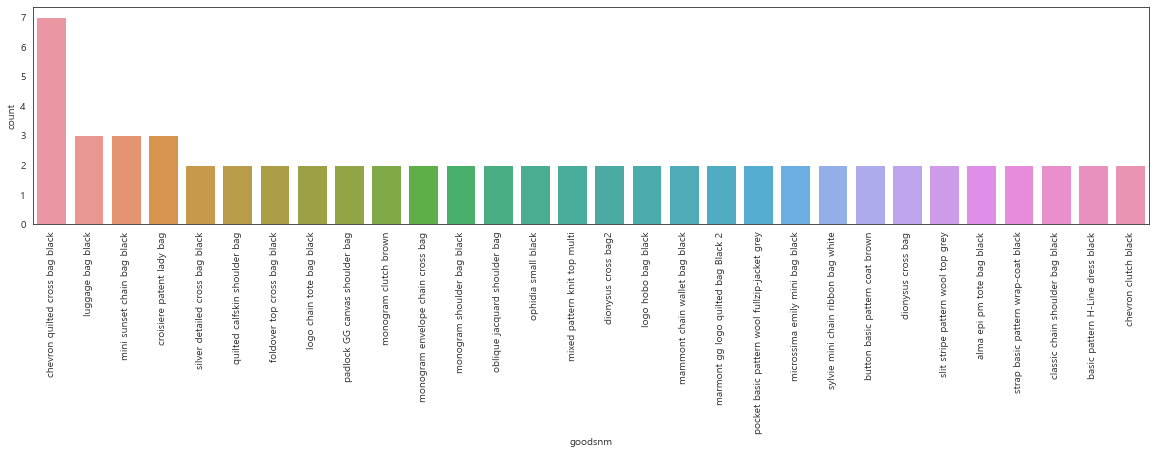

In [85]:
# 1월 인기 제품 (goodsnm)
plt.figure(figsize = (20,4))
plt.xticks(rotation = 90)
g = sns.barplot(x='goodsnm',y='count',data=df_jan_top)

In [86]:
# 2월 인기 제품
df_feb_top.head()

,order_month,goodsnm,sub_type,count,pct
446,2,chevron quilted cross bag black,가방,7,1.54
582,2,padlock GG canvas shoulder bag,가방,5,1.10
451,2,classic clutch black,가방,5,1.10
382,2,boy chanel clutch black,가방,5,1.10
484,2,epi tote bag black,가방,4,0.88


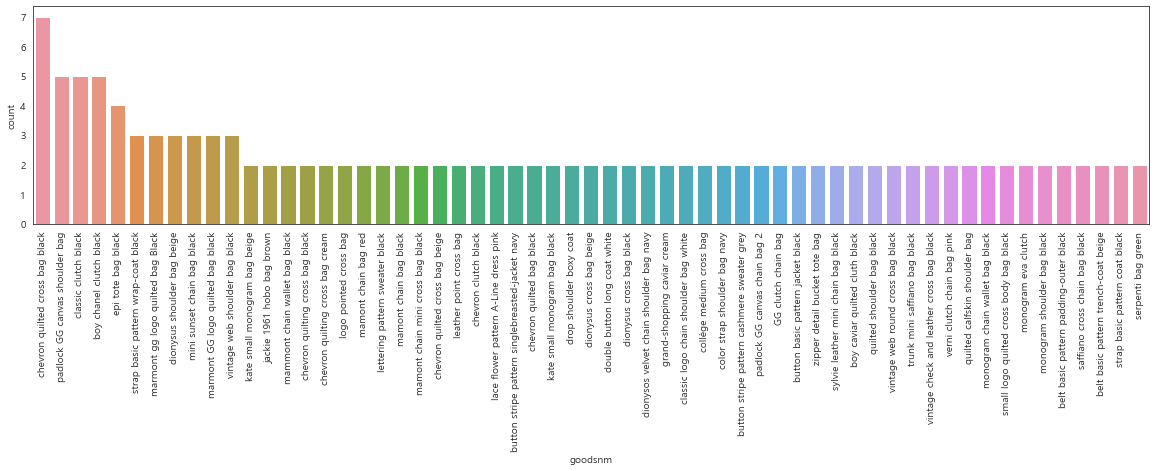

In [87]:
# 2월 인기 제품 (goodsnm)
plt.figure(figsize = (20,4))
plt.xticks(rotation = 90)
g = sns.barplot(x='goodsnm',y='count',data=df_feb_top)

In [88]:
# 3월 인기 제품
df_mar_top.head()

,order_month,goodsnm,sub_type,count,pct
861,3,chevron quilted cross bag black,가방,9,1.41
867,3,classic clutch black,가방,7,1.10
790,3,boy chanel clutch black,가방,6,0.94
913,3,flap cross bag black,가방,6,0.94
889,3,dionysus cross bag beige,가방,4,0.63


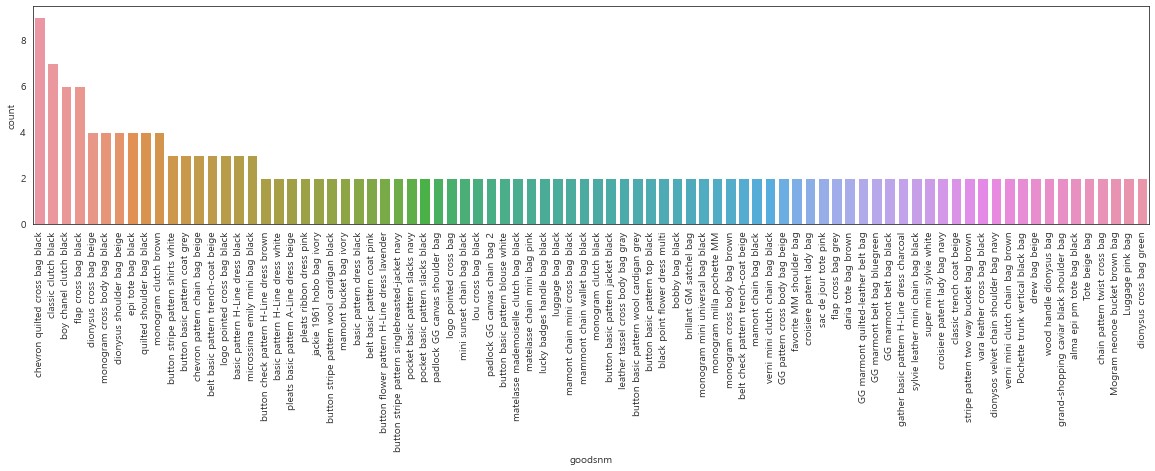

In [89]:
# 3월 인기 제품 (goodsnm)
plt.figure(figsize = (20,4))
plt.xticks(rotation = 90)
g = sns.barplot(x='goodsnm',y='count',data=df_mar_top)

In [90]:
print(f'1월에 2건 이상 대여된 제품 : {df_jan_top.shape[0]}개')
print(f'2월에 2건 이상 대여된 제품 : {df_feb_top.shape[0]}개')
print(f'3월에 2건 이상 대여된 제품 : {df_mar_top.shape[0]}개')

1월에 2건 이상 대여된 제품 : 30개
2월에 2건 이상 대여된 제품 : 59개
3월에 2건 이상 대여된 제품 : 84개


⚡인사이트⚡ 
- 월별 가장 인기가 많았던 제품은 'Saint Laurent' 브랜드의 'chevron quilted cross bag black'으로, 홈페이지 조회시 총 5개 제품이 등록되어 있음
- 월별 Top 5는 모두 가방 제품
- 대여 건수가 2 이상이었던 제품 개수는 1->3월로 갈수록 30->59->84개로 늘어남

### 3) 유저별 대여제품 건수

In [91]:
# order_month, user로 groupby
df_monthly_user = df.groupby(['order_month', 'user'])['p_type'].count().reset_index().sort_values(
    by = 'p_type', ascending = False).rename(columns = {'p_type' : 'count'})
df_monthly_user

,order_month,user,count
952,3,a1149461,11
969,3,a1149583,10
153,1,a1142677,9
183,1,a1143701,7
1220,3,a189404,7
...,...,...,...
442,2,a1145380,1
441,2,a1145376,1
440,2,a1145353,1
439,2,a1145346,1


In [92]:
# 월별 대여 건수가 2 이상이었던 활성유저 확인
df_jan = df_monthly_user[df_monthly_user['order_month'] == 1]
df_feb = df_monthly_user[df_monthly_user['order_month'] == 2]
df_mar = df_monthly_user[df_monthly_user['order_month'] == 3]

df_jan['pct'] = df_jan['count'] / np.sum(df_jan['count']) * 100
df_feb['pct'] = df_feb['count'] / np.sum(df_feb['count']) * 100
df_mar['pct'] = df_mar['count'] / np.sum(df_mar['count']) * 100

df_jan_top = df_jan[df_jan['count'] != 1]
df_feb_top = df_feb[df_feb['count'] != 1]
df_mar_top = df_mar[df_mar['count'] != 1]

In [93]:
# 1월 활성유저
df_jan_top.head()

,order_month,user,count,pct
153,1,a1142677,9,2.39
183,1,a1143701,7,1.86
104,1,a1140758,5,1.33
80,1,a1139028,4,1.06
154,1,a1142679,4,1.06


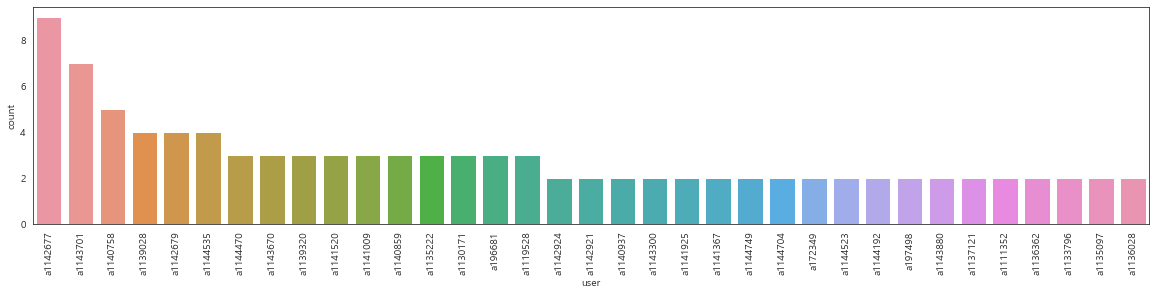

In [94]:
# 1월 활성유저
plt.figure(figsize = (20,4))
plt.xticks(rotation = 90)
g = sns.barplot(x='user',y='count',data=df_jan_top)

In [95]:
# 2월 활성유저
df_feb_top.head()

,order_month,user,count,pct
346,2,a1129550,6,1.32
515,2,a1146366,4,0.88
572,2,a1146852,4,0.88
361,2,a1139388,4,0.88
475,2,a1145686,3,0.66


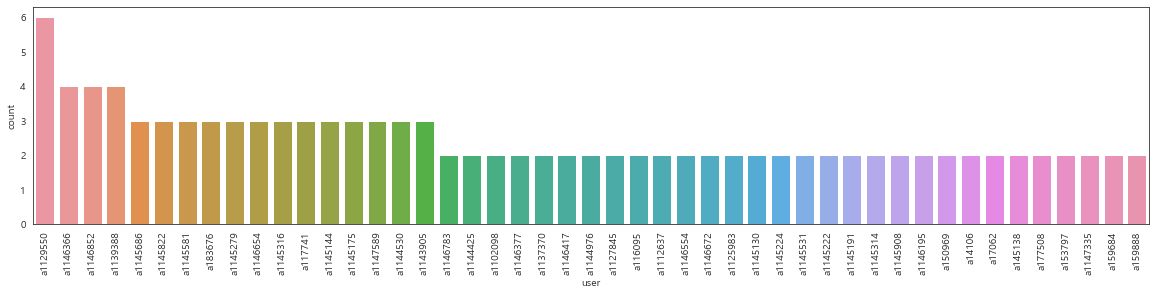

In [96]:
# 2월 활성유저
plt.figure(figsize = (20,4))
plt.xticks(rotation = 90)
g = sns.barplot(x='user',y='count',data=df_feb_top)

In [97]:
# 3월 활성유저
df_mar_top.head()

,order_month,user,count,pct
952,3,a1149461,11,1.72
969,3,a1149583,10,1.56
1220,3,a189404,7,1.10
962,3,a1149542,6,0.94
1216,3,a187924,6,0.94


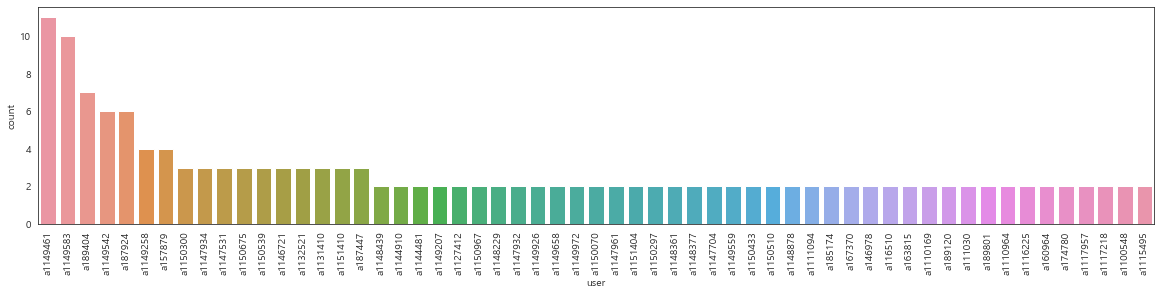

In [98]:
# 3월 활성유저
plt.figure(figsize = (20,4))
plt.xticks(rotation = 90)
g = sns.barplot(x='user',y='count',data=df_mar_top)

In [99]:
print(f'1월에 2건 이상 대여한 유저 : {df_jan_top.shape[0]}명')
print(f'2월에 2건 이상 대여한 유저 : {df_feb_top.shape[0]}명')
print(f'3월에 2건 이상 대여한 유저 : {df_mar_top.shape[0]}명')

1월에 2건 이상 대여한 유저 : 35명
2월에 2건 이상 대여한 유저 : 47명
3월에 2건 이상 대여한 유저 : 57명


In [100]:
jan_over4 = df_jan_top[df_jan_top['count']>=4].shape[0]
feb_over4 = df_feb_top[df_feb_top['count']>=4].shape[0]
mar_over4 = df_mar_top[df_mar_top['count']>=4].shape[0]

jan_over4_pct = round(df_jan_top[df_jan_top['count']>=4].shape[0] / df_jan_top.shape[0],2)*100
feb_over4_pct = round(df_feb_top[df_feb_top['count']>=4].shape[0] / df_feb_top.shape[0],2)*100
mar_over4_pct = round(df_mar_top[df_mar_top['count']>=4].shape[0] / df_mar_top.shape[0],2)*100

print(f'1월에 4건 이상 대여한 유저 : {jan_over4}명 ({jan_over4_pct}%)')
print(f'2월에 4건 이상 대여한 유저 : {feb_over4}명 ({feb_over4_pct}%)')
print(f'3월에 4건 이상 대여한 유저 : {mar_over4}명 ({mar_over4_pct}%)')

1월에 4건 이상 대여한 유저 : 6명 (17.0%)
2월에 4건 이상 대여한 유저 : 4명 (9.0%)
3월에 4건 이상 대여한 유저 : 7명 (12.0%)


⚡인사이트⚡ 
 - 주어진 데이터셋은 각 유저가 서비스를 처음으로 사용했을 때의 주문내역에 대한 것으로, 1,2,3월로 구분시 중복되는 유저는 없음
 - 월 대여가 2건 이상인 유저는 1->3월로 갈수록 35->47->57명으로 늘어나는 추세이나, 하지만 앞서 정의했던 헤비유저인 4건 이상인 구매 유저    는 감소하는 구간도 발생
 - 다만 클로젯 셰어 입장에서 헤비유저가 논헤비 유저에 비해 더 좋은 고객인지는 추가 정보가 필요. 헤비유저가 계속해서 물건을 많이 대여한다  는 보장x
 - 여러가지 복합적인 요소를 고려해 헤비유저와 논 헤비유저의 가치를 이끌어 낼 수 있다면 마케팅 전략 수립에 많은 도움이 될듯 함

4) 주문요일 
 - Monday - 0 / Sunday - 6

In [101]:
# order_month, order_dayofweek로 groupby
df_monthly_dayofweek = df.groupby(['order_month', 'order_dayofweek'])['p_type'].count().reset_index().sort_values(
    by = 'p_type', ascending = False).rename(columns = {'p_type' : 'count'})
df_monthly_dayofweek

,order_month,order_dayofweek,count
16,3,2,184
15,3,1,130
17,3,3,100
8,2,1,98
10,2,3,93
3,1,3,92
14,3,0,87
9,2,2,81
11,2,4,73
18,3,4,70


In [102]:
# 월별 요일 데이터 확인
df_jan = df_monthly_dayofweek[df_monthly_dayofweek['order_month'] == 1]
df_feb = df_monthly_dayofweek[df_monthly_dayofweek['order_month'] == 2]
df_mar = df_monthly_dayofweek[df_monthly_dayofweek['order_month'] == 3]

df_jan['pct'] = df_jan['count'] / np.sum(df_jan['count']) * 100
df_feb['pct'] = df_feb['count'] / np.sum(df_feb['count']) * 100
df_mar['pct'] = df_mar['count'] / np.sum(df_mar['count']) * 100

In [103]:
# 1월 요일별 대여건수
df_jan

,order_month,order_dayofweek,count,pct
3,1,3,92,24.40
2,1,2,67,17.77
1,1,1,63,16.71
4,1,4,52,13.79
0,1,0,51,13.53
6,1,6,33,8.75
5,1,5,19,5.04


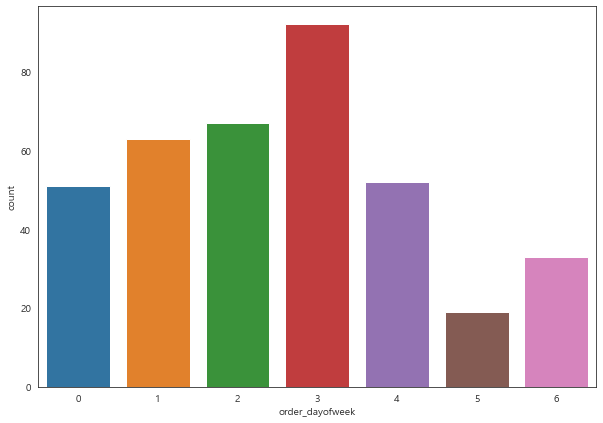

In [104]:
# 1월 요일별 대여건수
g = sns.barplot(x='order_dayofweek',y='count',data=df_jan)

In [105]:
# 2월 요일별 대여건수
df_feb

,order_month,order_dayofweek,count,pct
8,2,1,98,21.54
10,2,3,93,20.44
9,2,2,81,17.80
11,2,4,73,16.04
7,2,0,65,14.29
13,2,6,30,6.59
12,2,5,15,3.30


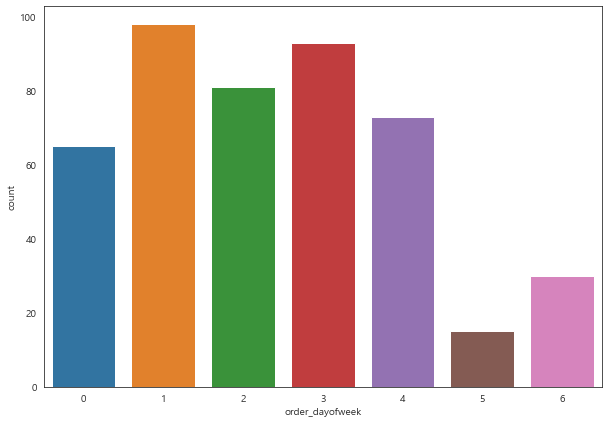

In [106]:
# 2월 요일별 대여건수
g = sns.barplot(x='order_dayofweek',y='count',data=df_feb)

In [107]:
# 3월 요일별 대여건수
df_mar

,order_month,order_dayofweek,count,pct
16,3,2,184,28.79
15,3,1,130,20.34
17,3,3,100,15.65
14,3,0,87,13.62
18,3,4,70,10.95
20,3,6,40,6.26
19,3,5,28,4.38


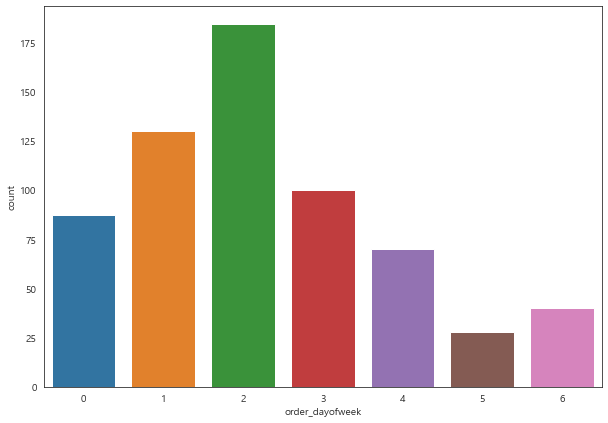

In [108]:
# 3월 요일별 대여건수
g = sns.barplot(x='order_dayofweek',y='count',data=df_mar)

In [109]:
jan_weekday = df_jan[df_jan['order_dayofweek'].isin([0,1,2,3,4])]['count'].sum()
jan_weekend = df_jan[df_jan['order_dayofweek'].isin([5,6])]['count'].sum()
jan_weekend_pct = round(df_jan[df_jan['order_dayofweek'].isin([5,6])]['pct'].sum(),1)

feb_weekday = df_feb[df_feb['order_dayofweek'].isin([0,1,2,3,4])]['count'].sum()
feb_weekend = df_feb[df_feb['order_dayofweek'].isin([5,6])]['count'].sum()
feb_weekend_pct = round(df_feb[df_feb['order_dayofweek'].isin([5,6])]['pct'].sum(),1)

mar_weekday = df_mar[df_mar['order_dayofweek'].isin([0,1,2,3,4])]['count'].sum()
mar_weekend = df_mar[df_mar['order_dayofweek'].isin([5,6])]['count'].sum()
mar_weekend_pct = round(df_mar[df_mar['order_dayofweek'].isin([5,6])]['pct'].sum(),1)

print(f'1월 평일 대여건수 : {jan_weekday}건, 주말 대여건수 : {jan_weekend}건, 주말 비중 : {jan_weekend_pct}%')
print(f'2월 평일 대여건수 : {feb_weekday}건, 주말 대여건수 : {feb_weekend}건, 주말 비중 : {feb_weekend_pct}%')
print(f'3월 평일 대여건수 : {mar_weekday}건, 주말 대여건수 : {mar_weekend}건, 주말 비중 : {mar_weekend_pct}%')

1월 평일 대여건수 : 325건, 주말 대여건수 : 52건, 주말 비중 : 13.8%
2월 평일 대여건수 : 410건, 주말 대여건수 : 45건, 주말 비중 : 9.9%
3월 평일 대여건수 : 571건, 주말 대여건수 : 68건, 주말 비중 : 10.6%


⚡인사이트⚡ 
 - 매월 화~목요일 대여 건수가 높으며, 주말은 상대적으로 낮음
 - 주말에 사용하려는 제품을 주중에 주문하려는 수요가 있는 것으로 추측해볼 수 있음
 - 주말 주문에 관한 수요를 더 늘릴 필요가 있음
 - 특정 요일에 주문 수요가 쏠린다면 제품 회전에 문제 생기고 소비자들이 원하는 제품을 주문하지 못할 확률이 커지므로 때문에 균등한 분포를 만들 필요가 있음
 
⚡마케팅 제안⚡ 
 - 직장인 여성들을 위한 마케팅 전략 ("회사에서 패피가 되고싶다면? 클로젯셰어에서 다음주에 입을 오피스룩 대여하세요!")

⚡사용중인 마케팅⚡ 

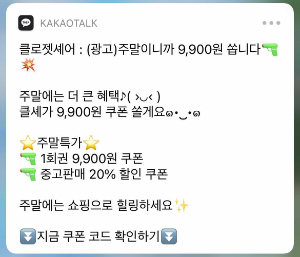


### 5) 이용권 
 - 4days / 7days

In [110]:
# order_month, p_type로 groupby
df_monthly_ptype = df.groupby(['order_month', 'p_type'])['sub_type'].count().reset_index().sort_values(
    by = 'sub_type', ascending = False).rename(columns = {'sub_type' : 'count'})
df_monthly_ptype

,order_month,p_type,count
4,3,4days,381
2,2,4days,276
5,3,7days,258
0,1,4days,237
3,2,7days,179
1,1,7days,140


In [111]:
# 월별 p_type 확인
df_jan = df_monthly_ptype[df_monthly_ptype['order_month'] == 1]
df_feb = df_monthly_ptype[df_monthly_ptype['order_month'] == 2]
df_mar = df_monthly_ptype[df_monthly_ptype['order_month'] == 3]

df_jan['pct'] = df_jan['count'] / np.sum(df_jan['count']) * 100
df_feb['pct'] = df_feb['count'] / np.sum(df_feb['count']) * 100
df_mar['pct'] = df_mar['count'] / np.sum(df_mar['count']) * 100

In [112]:
# 1월 p_type
df_jan

,order_month,p_type,count,pct
0,1,4days,237,62.86
1,1,7days,140,37.14


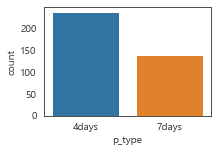

In [113]:
# 1월 p_type
plt.figure(figsize = (3,2))
g = sns.barplot(x='p_type',y='count',data=df_jan)

In [114]:
# 2월 p_type
df_feb

,order_month,p_type,count,pct
2,2,4days,276,60.66
3,2,7days,179,39.34


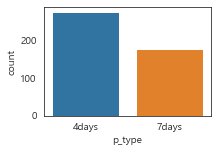

In [115]:
# 2월 p_type
plt.figure(figsize = (3,2))
g = sns.barplot(x='p_type',y='count',data=df_feb)

In [116]:
# 3월 p_type
df_mar

,order_month,p_type,count,pct
4,3,4days,381,59.62
5,3,7days,258,40.38


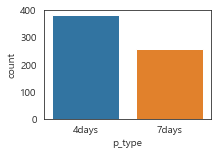

In [117]:
# 3월 p_type
plt.figure(figsize = (3,2))
g = sns.barplot(x='p_type',y='count',data=df_mar)

In [118]:
jan_ptype = df_jan.loc[df_jan['p_type'] == '4days', 'count'].sum()
jan_4days_pct = round(df_jan.loc[df_jan['p_type'] == '4days', 'pct'].sum(),1)

feb_ptype = df_feb.loc[df_feb['p_type'] == '4days', 'count'].sum()
feb_4days_pct = round(df_feb.loc[df_feb['p_type'] == '4days', 'pct'].sum(),1)

mar_ptype = df_mar.loc[df_mar['p_type'] == '4days', 'count'].sum()
mar_4days_pct = round(df_mar.loc[df_mar['p_type'] == '4days', 'pct'].sum(),1)

print(f'1월 p_type : {jan_ptype}건, 4days 비중 : {jan_4days_pct}%')
print(f'2월 p_type : {feb_ptype}건, 4days 비중 : {feb_4days_pct}%')
print(f'3월 p_type : {mar_ptype}건, 4days 비중 : {mar_4days_pct}%')

1월 p_type : 237건, 4days 비중 : 62.9%
2월 p_type : 276건, 4days 비중 : 60.7%
3월 p_type : 381건, 4days 비중 : 59.6%


⚡인사이트⚡ 
- 1->3월로 가면서 4days 대여 비중이 줄어드는 추세
- 7days 이용권의 단가가 높긴 하나, 인기있는 제품은 회전율을 높이는 것이 이익일 수 있음
- 회전이 활발한 제품인지 여부, 세탁에 소요되는 일수, 왕복배송에 소요되는 일수, 배송비 등을 종합적으로 고려하여 제품별로 4일권, 7일권 중에 어떤 타입이 더 유리한지 파악하여 마케팅에 활용할 필요가 있음
ex) 4일권 49,000원, 7일권 59,000원인 인기제품이 30일간 대여되는 상황 (기간 공백없이 연달아 대여)
  세탁에 1일, 왕복배송에는 3일, 5천원 배송비가 든다고 가정하면 7일권 판매가 근소한 차이로 유리함 

|p_type|매출|왕복배송비|1회 대여시 소요일|30일간 대여가능 횟수|수익| 
|------|----|----------|-----------------|-------------|----| 
|4일권|49000|5000|8일|30일 / 8일 = 3.75회|(44000-5000)* 3.75 = 146250원| 
|7일권|59000|5000|11일|30일 / 11일 = 2.73회|(59000-5000) * 2.73 = 147420원|


### 5) 제품 종류

sub_type : '가방', '드레스', '아우터', 

In [119]:
# order_month, sub_type로 groupby
df_monthly_subtype = df.groupby(['order_month', 'sub_type'])['p_type'].count().reset_index().sort_values(
    by = 'p_type', ascending = False).rename(columns = {'p_type' : 'count'})
df_monthly_subtype

,order_month,sub_type,count
12,3,가방,310
6,2,가방,234
0,1,가방,148
13,3,드레스,128
9,2,아우터,97
15,3,아우터,87
3,1,아우터,83
7,2,드레스,69
14,3,상의,65
1,1,드레스,64


In [120]:
# 월별 sub_type 확인
df_jan = df_monthly_subtype[df_monthly_subtype['order_month'] == 1]
df_feb = df_monthly_subtype[df_monthly_subtype['order_month'] == 2]
df_mar = df_monthly_subtype[df_monthly_subtype['order_month'] == 3]

df_jan['pct'] = df_jan['count'] / np.sum(df_jan['count']) * 100
df_feb['pct'] = df_feb['count'] / np.sum(df_feb['count']) * 100
df_mar['pct'] = df_mar['count'] / np.sum(df_mar['count']) * 100

In [121]:
# 1월 sub_type
df_jan

,order_month,sub_type,count,pct
0,1,가방,148,39.26
3,1,아우터,83,22.02
1,1,드레스,64,16.98
2,1,상의,60,15.92
5,1,하의,11,2.92
4,1,투피스,11,2.92


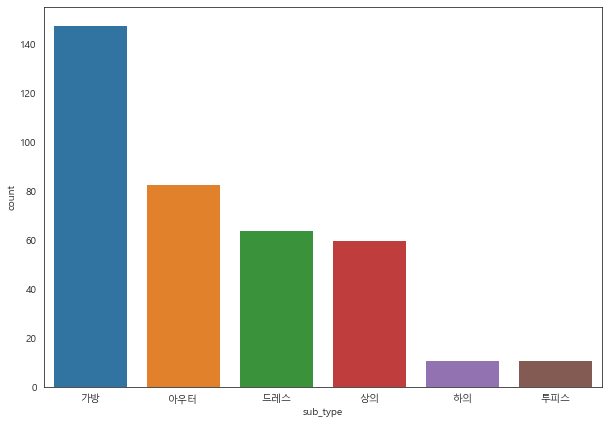

In [122]:
# 1월 sub_type
g = sns.barplot(x='sub_type',y='count',data=df_jan)

In [123]:
# 2월 sub_type
df_feb

,order_month,sub_type,count,pct
6,2,가방,234,51.43
9,2,아우터,97,21.32
7,2,드레스,69,15.16
8,2,상의,39,8.57
11,2,하의,9,1.98
10,2,투피스,7,1.54


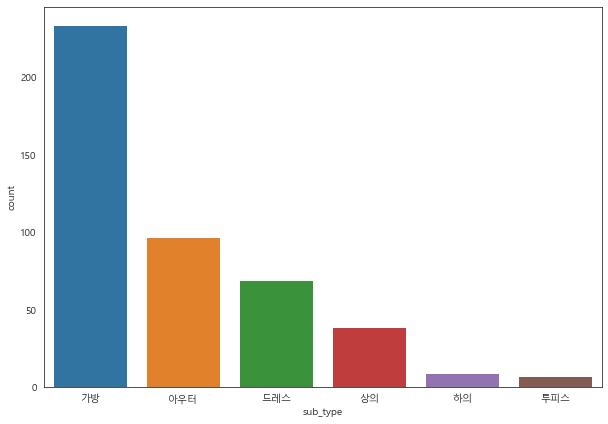

In [124]:
# 2월 sub_type
g = sns.barplot(x='sub_type',y='count',data=df_feb)

In [125]:
# 3월 sub_type
df_mar

,order_month,sub_type,count,pct
12,3,가방,310,48.51
13,3,드레스,128,20.03
15,3,아우터,87,13.62
14,3,상의,65,10.17
17,3,하의,38,5.95
16,3,투피스,11,1.72


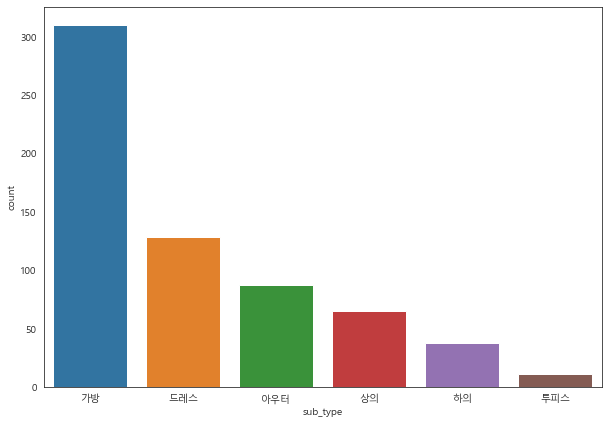

In [126]:
# 3월 sub_type
g = sns.barplot(x='sub_type',y='count',data=df_mar)

In [127]:
# BA 기준 월별 변화 확인
jan_subtype = df_jan.loc[df_jan['sub_type'] == '가방', 'count'].sum()
jan_BA_pct = round(df_jan.loc[df_jan['sub_type'] == '가방', 'pct'].sum(),1)
feb_subtype = df_feb.loc[df_feb['sub_type'] == '가방', 'count'].sum()
feb_BA_pct = round(df_feb.loc[df_feb['sub_type'] == '가방', 'pct'].sum(),1)
mar_subtype = df_mar.loc[df_mar['sub_type'] == '가방', 'count'].sum()
mar_BA_pct = round(df_mar.loc[df_mar['sub_type'] == '가방', 'pct'].sum(),1)

print(f'1월 sub_type : {jan_subtype}건, 가방 비중 : {jan_BA_pct}%')
print(f'2월 sub_type : {feb_subtype}건, 가방 비중 : {feb_BA_pct}%')
print(f'3월 sub_type : {mar_subtype}건, 가방 비중 : {mar_BA_pct}%')

1월 sub_type : 148건, 가방 비중 : 39.3%
2월 sub_type : 234건, 가방 비중 : 51.4%
3월 sub_type : 310건, 가방 비중 : 48.5%


In [128]:
# D 기준 월별 변화 확인
jan_subtype = df_jan.loc[df_jan['sub_type'] == '드레스', 'count'].sum()
jan_D_pct = round(df_jan.loc[df_jan['sub_type'] == '드레스', 'pct'].sum(),1)
feb_subtype = df_feb.loc[df_feb['sub_type'] == '드레스', 'count'].sum()
feb_D_pct = round(df_feb.loc[df_feb['sub_type'] == '드레스', 'pct'].sum(),1)
mar_subtype = df_mar.loc[df_mar['sub_type'] == '드레스', 'count'].sum()
mar_D_pct = round(df_mar.loc[df_mar['sub_type'] == '드레스', 'pct'].sum(),1)

print(f'1월 sub_type : {jan_subtype}건, 드레스 비중 : {jan_D_pct}%')
print(f'2월 sub_type : {feb_subtype}건, 드레스 비중 : {feb_D_pct}%')
print(f'3월 sub_type : {mar_subtype}건, 드레스 비중 : {mar_D_pct}%')

1월 sub_type : 64건, 드레스 비중 : 17.0%
2월 sub_type : 69건, 드레스 비중 : 15.2%
3월 sub_type : 128건, 드레스 비중 : 20.0%


In [129]:
# O 기준 월별 변화 확인
jan_subtype = df_jan.loc[df_jan['sub_type'] == '아우터', 'count'].sum()
jan_O_pct = round(df_jan.loc[df_jan['sub_type'] == '아우터', 'pct'].sum(),1)
feb_subtype = df_feb.loc[df_feb['sub_type'] == '아우터', 'count'].sum()
feb_O_pct = round(df_feb.loc[df_feb['sub_type'] == '아우터', 'pct'].sum(),1)
mar_subtype = df_mar.loc[df_mar['sub_type'] == '아우터', 'count'].sum()
mar_O_pct = round(df_mar.loc[df_mar['sub_type'] == '아우터', 'pct'].sum(),1)

print(f'1월 sub_type : {jan_subtype}건, 아우터 비중 : {jan_O_pct}%')
print(f'2월 sub_type : {feb_subtype}건, 아우터 비중 : {feb_O_pct}%')
print(f'3월 sub_type : {mar_subtype}건, 아우터 비중 : {mar_O_pct}%')

1월 sub_type : 83건, 아우터 비중 : 22.0%
2월 sub_type : 97건, 아우터 비중 : 21.3%
3월 sub_type : 87건, 아우터 비중 : 13.6%


In [130]:
df.sub_type.value_counts()

가방     692
아우터    267
드레스    261
상의     164
하의      58
투피스     29
Name: sub_type, dtype: int64

In [131]:
# T 기준 월별 변화 확인
jan_subtype = df_jan.loc[df_jan['sub_type'] == '상의', 'count'].sum()
jan_T_pct = round(df_jan.loc[df_jan['sub_type'] == '상의', 'pct'].sum(),1)
feb_subtype = df_feb.loc[df_feb['sub_type'] == '상의', 'count'].sum()
feb_T_pct = round(df_feb.loc[df_feb['sub_type'] == '상의', 'pct'].sum(),1)
mar_subtype = df_mar.loc[df_mar['sub_type'] == '상의', 'count'].sum()
mar_T_pct = round(df_mar.loc[df_mar['sub_type'] == '상의', 'pct'].sum(),1)

print(f'1월 sub_type : {jan_subtype}건, 상의 비중 : {jan_T_pct}%')
print(f'2월 sub_type : {feb_subtype}건, 상의 비중 : {feb_T_pct}%')
print(f'3월 sub_type : {mar_subtype}건, 상의 비중 : {mar_T_pct}%')

1월 sub_type : 60건, 상의 비중 : 15.9%
2월 sub_type : 39건, 상의 비중 : 8.6%
3월 sub_type : 65건, 상의 비중 : 10.2%


In [132]:
# B 기준 월별 변화 확인
jan_subtype = df_jan.loc[df_jan['sub_type'] == '하의', 'count'].sum()
jan_B_pct = round(df_jan.loc[df_jan['sub_type'] == '하의', 'pct'].sum(),1)
feb_subtype = df_feb.loc[df_feb['sub_type'] == '하의', 'count'].sum()
feb_B_pct = round(df_feb.loc[df_feb['sub_type'] == '하의', 'pct'].sum(),1)
mar_subtype = df_mar.loc[df_mar['sub_type'] == '하의', 'count'].sum()
mar_B_pct = round(df_mar.loc[df_mar['sub_type'] == '하의', 'pct'].sum(),1)

print(f'1월 sub_type : {jan_subtype}건, 하의 비중 : {jan_B_pct}%')
print(f'2월 sub_type : {feb_subtype}건, 하의 비중 : {feb_B_pct}%')
print(f'3월 sub_type : {mar_subtype}건, 하의 비중 : {mar_B_pct}%')

1월 sub_type : 11건, 하의 비중 : 2.9%
2월 sub_type : 9건, 하의 비중 : 2.0%
3월 sub_type : 38건, 하의 비중 : 5.9%


In [133]:
# TP 기준 월별 변화 확인
jan_subtype = df_jan.loc[df_jan['sub_type'] == '투피스', 'count'].sum()
jan_TP_pct = round(df_jan.loc[df_jan['sub_type'] == '투피스', 'pct'].sum(),1)
feb_subtype = df_feb.loc[df_feb['sub_type'] == '투피스', 'count'].sum()
feb_TP_pct = round(df_feb.loc[df_feb['sub_type'] == '투피스', 'pct'].sum(),1)
mar_subtype = df_mar.loc[df_mar['sub_type'] == '투피스', 'count'].sum()
mar_TP_pct = round(df_mar.loc[df_mar['sub_type'] == '투피스', 'pct'].sum(),1)

print(f'1월 sub_type : {jan_subtype}건, 투피스 비중 : {jan_TP_pct}%')
print(f'2월 sub_type : {feb_subtype}건, 투피스 비중 : {feb_TP_pct}%')
print(f'3월 sub_type : {mar_subtype}건, 투피스 비중 : {mar_TP_pct}%')

1월 sub_type : 11건, 투피스 비중 : 2.9%
2월 sub_type : 7건, 투피스 비중 : 1.5%
3월 sub_type : 11건, 투피스 비중 : 1.7%


⚡인사이트⚡ 
- 매월 가장 인기있는 sub_type은 가방으로, 브랜드, 제품분석 결과를 봤을 때 명품가방 대여에 대한 수요가 높은 것으로 보임
- 인기있는 가방과 매치할 수 있는 의류를 제안하는 방식으로 크게 주목받지 못했던 의류 아이템의 대여횟수를 늘릴 수 있을 것으로 보임
- 아우터는 1->3월로 가면서 대여횟수 및 비중이 줄어들었으나 D는 2->3월 대여횟수가 크게 늘어남
- 계절과 관계있는 아이템들이 있는 것으로 보이며, 계절성을 활용한 마케팅 전략을 세울 수 있을 것으로 보임

6) 앱사용여부 
- Y - 사용 / N - 미사용

In [134]:
# order_month, app_yn으로 groupby
df_monthly_app = df.groupby(['order_month', 'app_yn'])['p_type'].count().reset_index().sort_values(
    by = 'p_type', ascending = False).rename(columns = {'p_type' : 'count'})
df_monthly_app

,order_month,app_yn,count
5,3,Y,538
3,2,Y,408
1,1,Y,349
4,3,N,101
2,2,N,47
0,1,N,28


In [135]:
# 월별 app_yn 확인
df_jan = df_monthly_app[df_monthly_app['order_month'] == 1]
df_feb = df_monthly_app[df_monthly_app['order_month'] == 2]
df_mar = df_monthly_app[df_monthly_app['order_month'] == 3]

df_jan['pct'] = df_jan['count'] / np.sum(df_jan['count']) * 100
df_feb['pct'] = df_feb['count'] / np.sum(df_feb['count']) * 100
df_mar['pct'] = df_mar['count'] / np.sum(df_mar['count']) * 100

In [136]:
# 1월 app_yn
df_jan

,order_month,app_yn,count,pct
1,1,Y,349,92.57
0,1,N,28,7.43


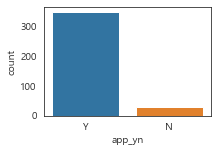

In [137]:
# 1월 app_yn
plt.figure(figsize = (3,2))
g = sns.barplot(x='app_yn',y='count',data=df_jan)

In [138]:
# 2월 app_yn
df_feb

,order_month,app_yn,count,pct
3,2,Y,408,89.67
2,2,N,47,10.33


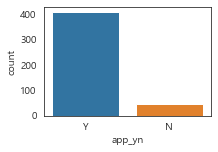

In [139]:
# 2월 app_yn
plt.figure(figsize = (3,2))
g = sns.barplot(x='app_yn',y='count',data=df_feb)

In [140]:
# 3월 app_yn
df_mar

,order_month,app_yn,count,pct
5,3,Y,538,84.19
4,3,N,101,15.81


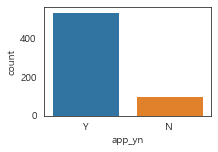

In [141]:
# 3월 app_yn
plt.figure(figsize = (3,2))
g = sns.barplot(x='app_yn',y='count',data=df_mar)

In [142]:
jan_app = df_jan.loc[df_jan['app_yn'] == 'Y', 'count'].sum()
jan_Y_pct = round(df_jan.loc[df_jan['app_yn'] == 'Y', 'pct'].sum(),1)

feb_app = df_feb.loc[df_feb['app_yn'] == 'Y', 'count'].sum()
feb_Y_pct = round(df_feb.loc[df_feb['app_yn'] == 'Y', 'pct'].sum(),1)

mar_app = df_mar.loc[df_mar['app_yn'] == 'Y', 'count'].sum()
mar_Y_pct = round(df_mar.loc[df_mar['app_yn'] == 'Y', 'pct'].sum(),1)

print(f'1월 app_yn : {jan_app}건, 앱이용 비중 : {jan_Y_pct}%')
print(f'2월 app_yn : {feb_app}건, 앱이용 비중 : {feb_Y_pct}%')
print(f'3월 app_yn : {mar_app}건, 앱이용 비중 : {mar_Y_pct}%')

1월 app_yn : 349건, 앱이용 비중 : 92.6%
2월 app_yn : 408건, 앱이용 비중 : 89.7%
3월 app_yn : 538건, 앱이용 비중 : 84.2%


⚡인사이트⚡ 
- 앱사용자 비중이 늘어날수록 유리할 것으로 보이나(앱푸시 가능, 방문빈도 확보), 1->3월에는 감소하는 추세

⚡마케팅 제안⚡ 
- 앱사용도를 높이기 위한 프로모션 전략 활용 필요

## ⚡제안사항⚡ 
### 브랜드 
- 인기 브랜드와의 콜라보 마케팅 전략 ("클로젯셰어에서 구찌 제품을 5회 이상 대여하신 분들께 드리는 신제품 체험 기회!")
### 제품 
- 인기 제품의 셰어링 등록을 유도하는 마케팅 전략 ("옷장에서 쉬고 있는 생로랑 크로스백, 클로젯셰어에서 열일하게 하세요!")
- 인기 제품은 회전율이 최대로 운영되고 있는지 물류, 배송상황 지속 점검
### 유저 
- 1회 주문시 대여 제품수를 늘릴 수 있는 인센티브 전략
- 대여하는 제품수가 많아질수록 높아지는 포인트 적립, 할인율, 늘어나는 대여기간 등
### 주문요일 
- 주말 주문 수량을 늘릴 수 있는 마케팅 전략 ("회사에서 패피가 되고싶다면? 클로젯셰어에서 다음주에 입을 오피스룩 대여하세요!")
### 이용권 
- 제품별로 4일권, 7일권 중 어떤 이용권으로 대여하는 것이 수익 제고에 유리한지 파악하여 마케팅에 활용
### 제품 카테고리 
- 인기있는 가방 제품에 매치할 수 있는 의류 아이템 코디 제안 ("보이 샤넬 클러치가 가장 빛나는 코디, 클로젯셰어에서 한번에 완성하세요!")
- 제품의 계절성을 고려한 마케팅 전략 ("결혼식 사진마다 같은 옷 입고 계셨다면? 클로젯셰어에서 특별한 날을 위한 코디를 준비하세요!")
### 앱 사용여부 
- 앱사용도를 높이기 위한 마케팅 전략 (앱에서만 사용 가능한 쿠폰 발행 등)
### 럭셔리 제품 여부 
- 유저별 선호 브랜드 제품을 더 자주 노출시키는 마케팅 전략

### Trash (사용미정)

In [143]:
px.bar(df_user.groupby('order_month').sum(), y='order_count', title='monthly 주문 수량', width=700, height=400)

In [144]:
px.bar(df_user.groupby('order_week').sum(), y='order_count', title='weekly 주문 수량', width=700, height=400)

In [145]:
px.bar(navertrend.groupby('week').sum().reset_index(), x='week', y='index', title='네이버트렌드 클로젯 셰어 검색', width=700, height=400)

In [146]:
px.bar(df_user.groupby('order_date').sum(),y='order_count',title='Daily 주문 수량',width=700, height=400)

In [147]:
px.bar(df_user.groupby('order_dayofweek').sum(), y='order_count',title='요일별 주문 수량', width=500, height=400)

#### 📍 insights
- Monthly : 1>2>3월로 갈수록 주문 상승세

- Weekly 
    1. `order_week` 6 급하락 (2021-02-08~2021-02-14 : 10-12 설연휴, 13-14 주말) 
    2. `order_week` 12 네이버트렌드도 급상승
    
- By dayofweek 
    1. 주말에 급하락
    2. 화수목마다 급상승하는 분포의 반복
    
    ➡ 금토일에 상품을 입기 위해서일 것


#### 인기 브랜드 분석

1. 집단 구분
    - 신규 유저 vs 기존 유저
    - 헤비 유저 vs non 헤비 유저
    

2. 상기 집단 구분에서 top 15 (주문수량기준) 내 브랜드 추출 후 중복되는 브랜드 : popular_brand_list 집중 분석
    - 명품 브랜드

In [148]:
s1 = set(df.query('seg_new==1').brandnm.value_counts().sort_values(ascending=False).head(15).index.tolist())
s2 = set(df.query('seg_new==0').brandnm.value_counts().sort_values(ascending=False).head(15).index.tolist())
s3 = set(df.query('seg_heavy==1').brandnm.value_counts().sort_values(ascending=False).head(15).index.tolist())
s4 = set(df.query('seg_heavy==0').brandnm.value_counts().sort_values(ascending=False).head(15).index.tolist())
popular_brand_list = list(s1&s2&s3&s4)
len(list(s1&s2&s3&s4))

5

In [149]:
#popular_brand_list.remove('N/A')
popular_brand_list

['Sandro', 'Fendi', 'Christian Dior', 'Burberry', 'Thom Browne']

##### 📍 insights
연관분석 결과 브랜드가 동일한 주에 구매될 확률 (0.9이상) 높은 itemsets

⚡ 비즈니스 관련 인사이트 생각해보기